# Determination of lightning length from light curves

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

/storage/experiments/2021/0605_bourka_radosovice 5


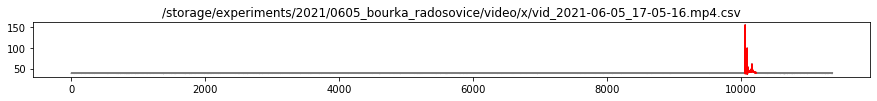

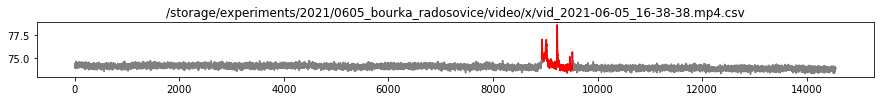

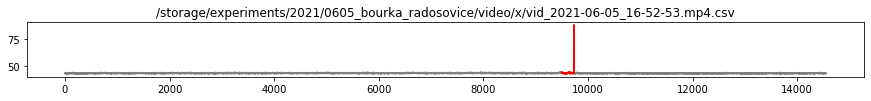

/storage/experiments/2021/0609_bourka_sobeslav 5


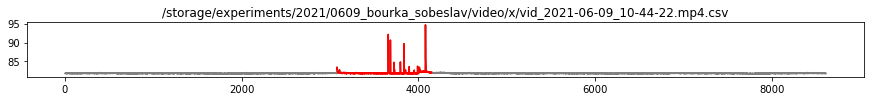

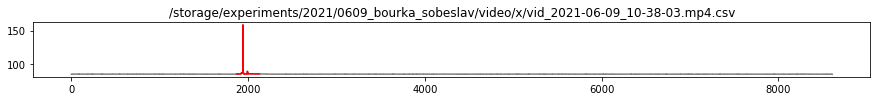

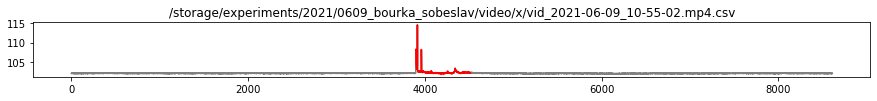

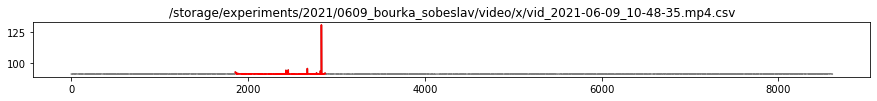

/storage/experiments/2021/0711_bourka_stiavnica 5


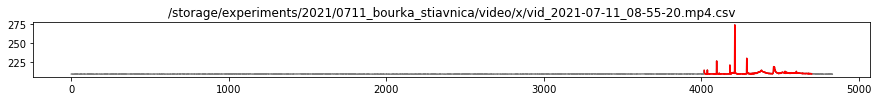

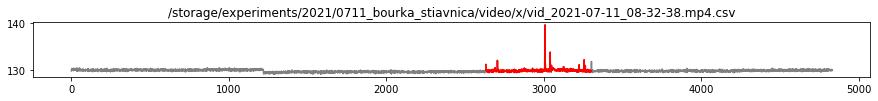

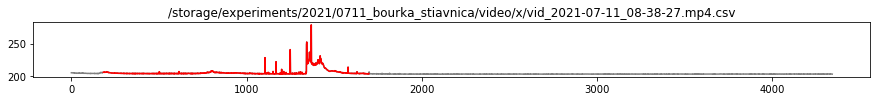

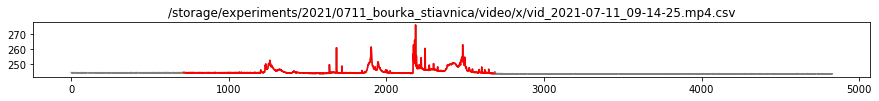

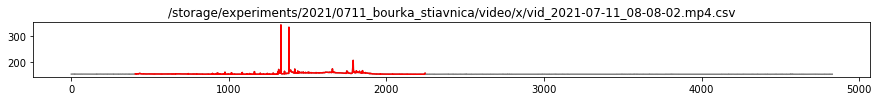

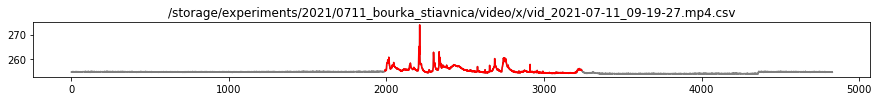

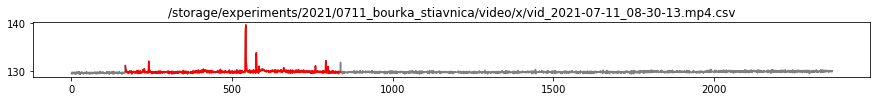

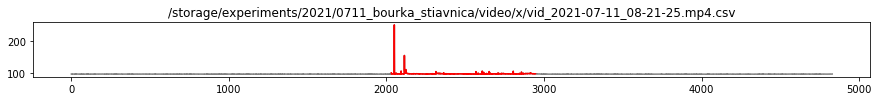

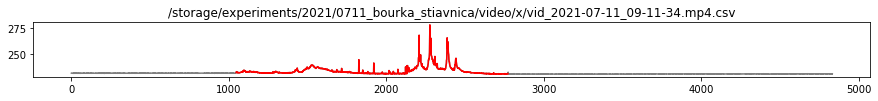

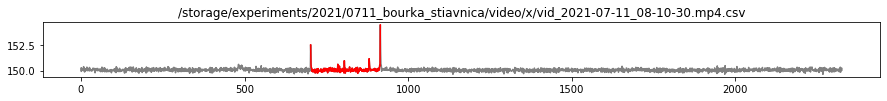

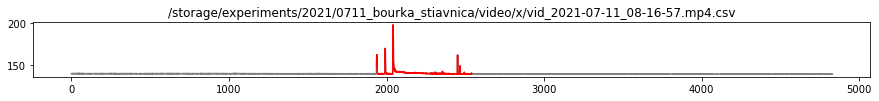

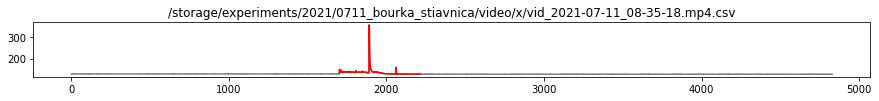

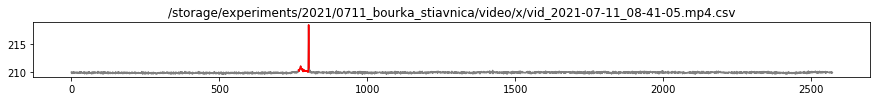

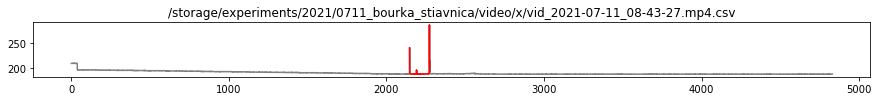

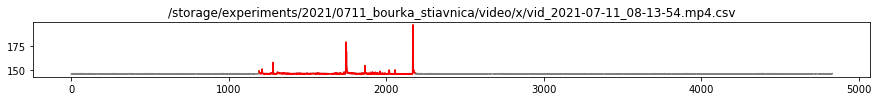

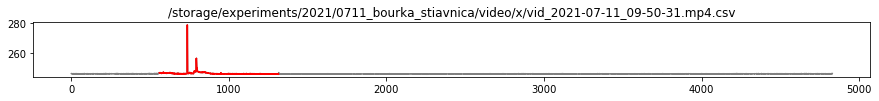

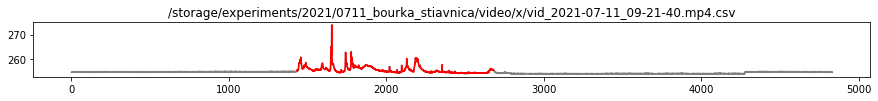

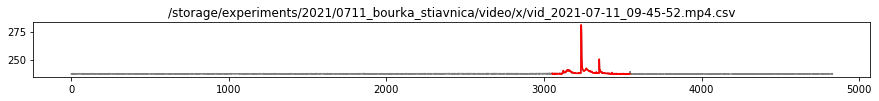

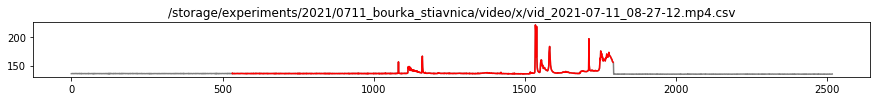

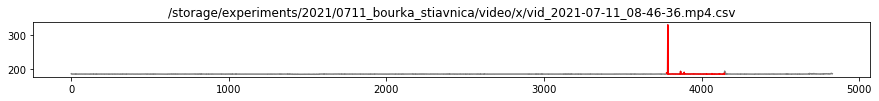

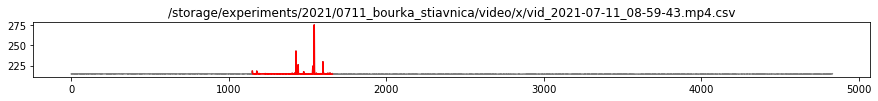

/storage/experiments/2021/0714_bourka_martin 5


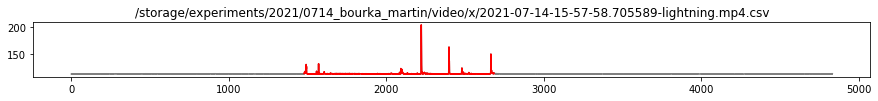

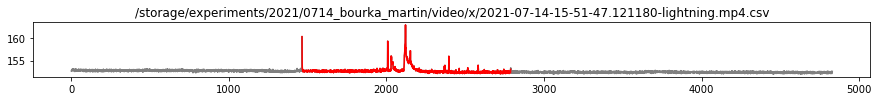

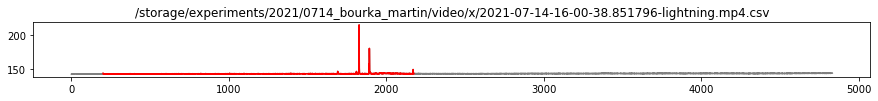

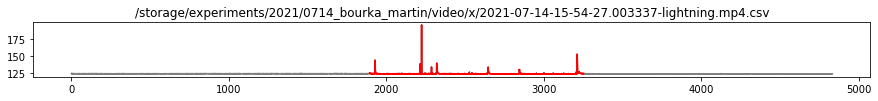

/storage/experiments/2021/0714_bourka_sobeslav 5


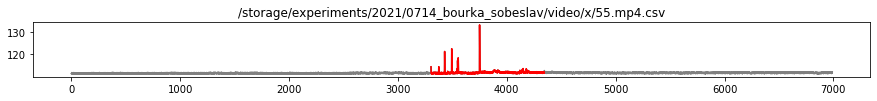

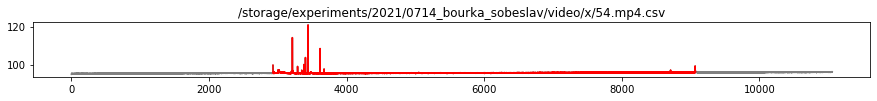

/storage/experiments/2021/0725_bourka_ratmirov 5


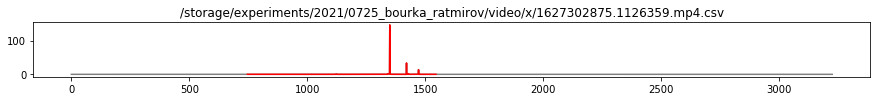

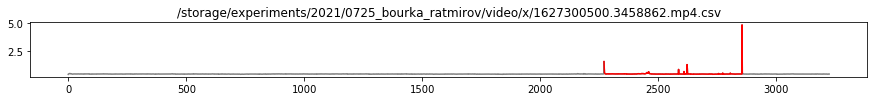

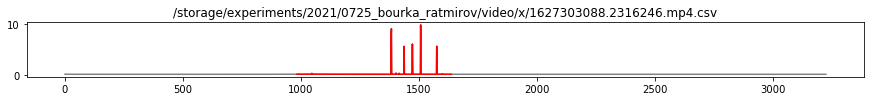

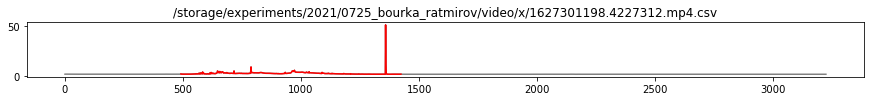

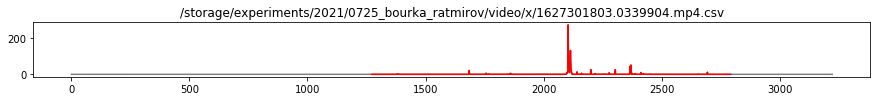

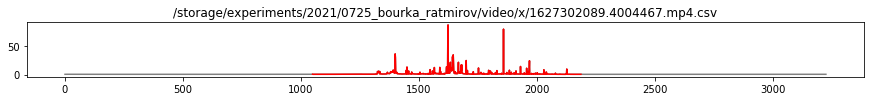

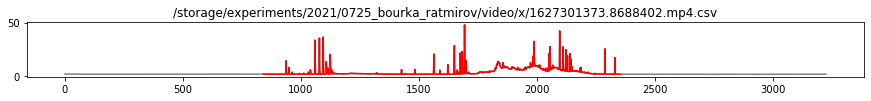

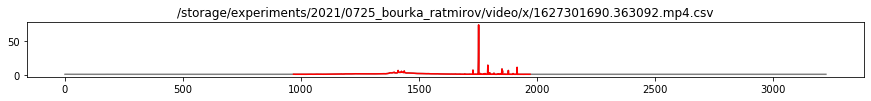

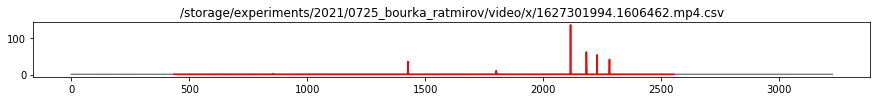

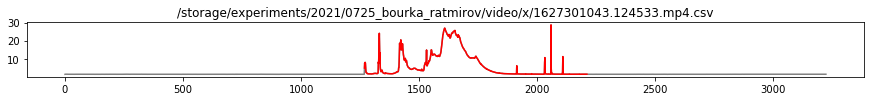

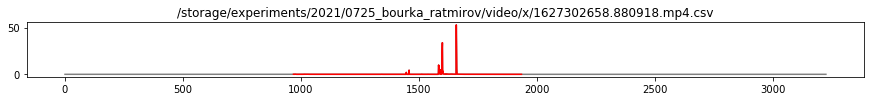

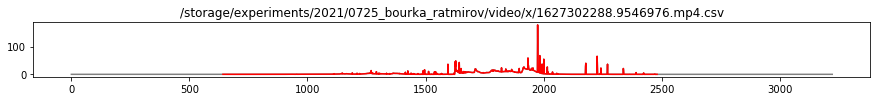

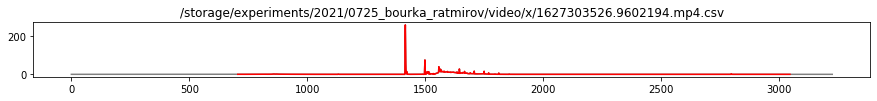

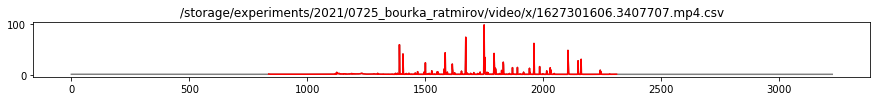

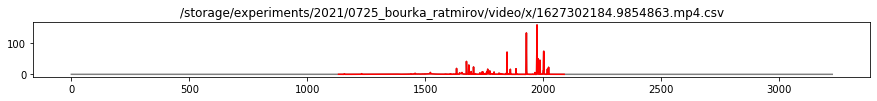

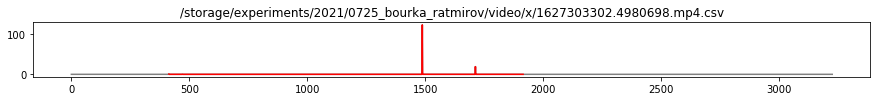

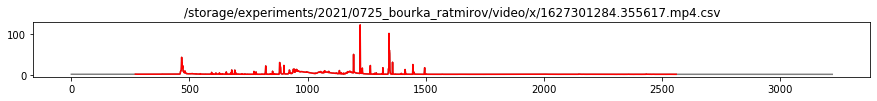

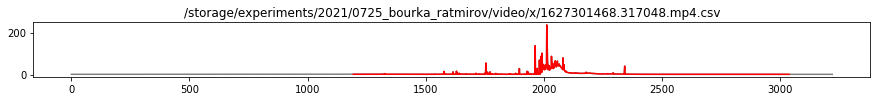

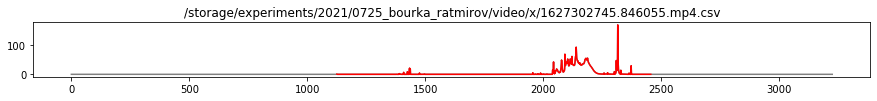

/storage/experiments/2021/0726_bourka_zabori 5


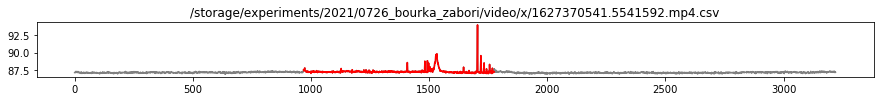

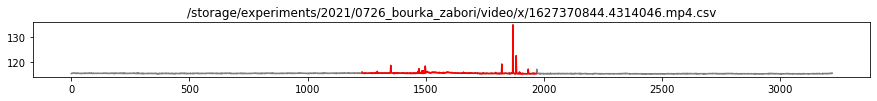

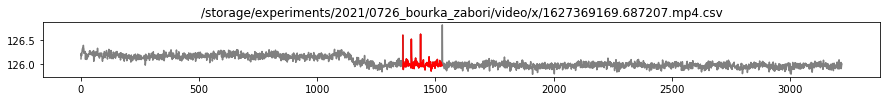

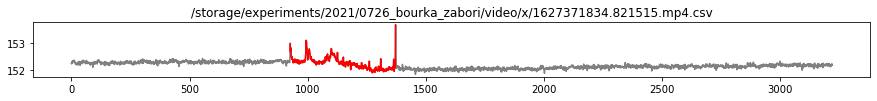

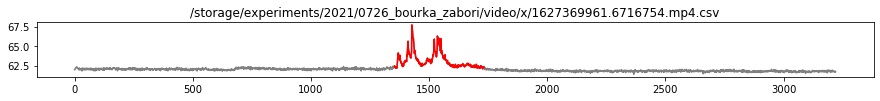

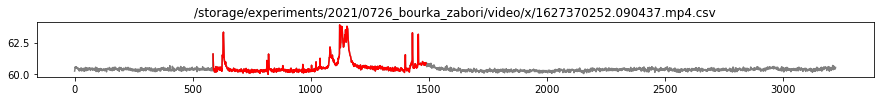

/storage/experiments/2021/0803_bourka_votice 5
/storage/experiments/2021/0807_bourka_sobeslav 5


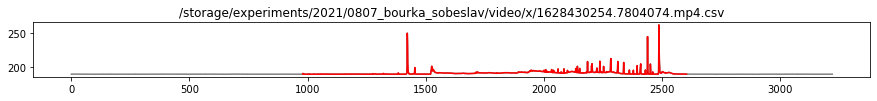

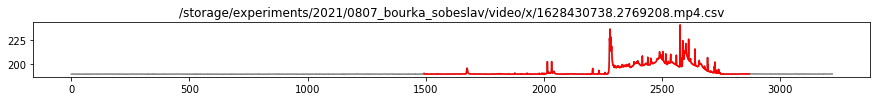

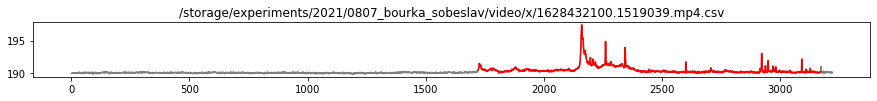

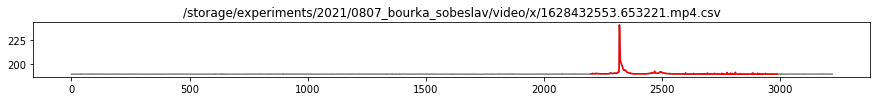

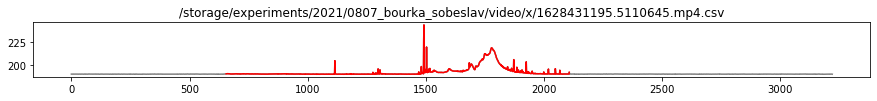

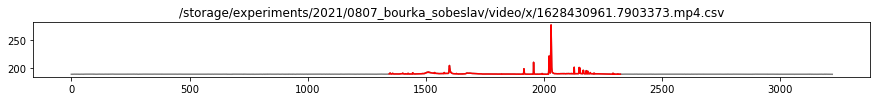

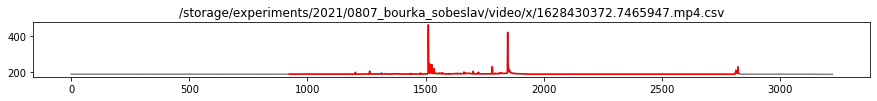

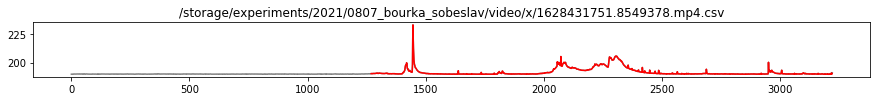

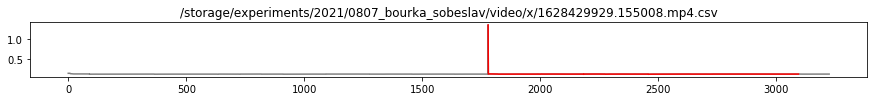

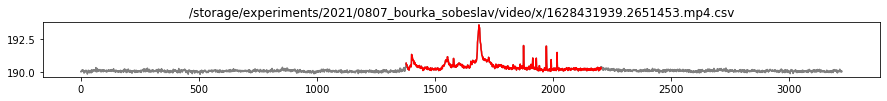

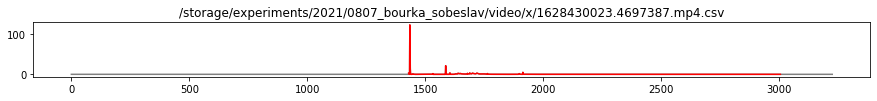

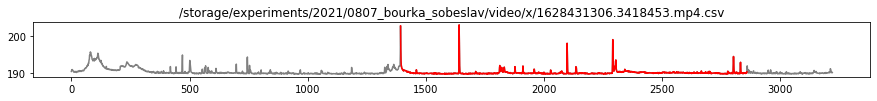

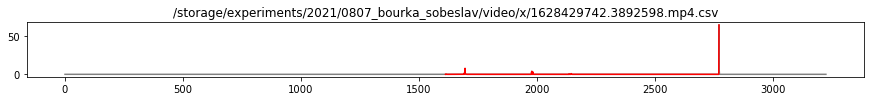

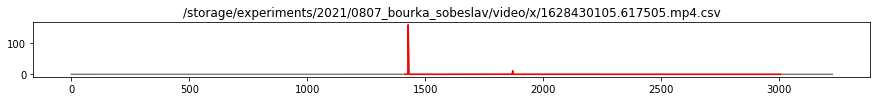

/storage/experiments/2021/0815_bourka_veseli_auto1 5


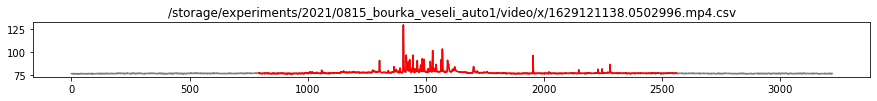

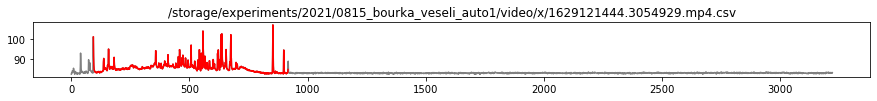

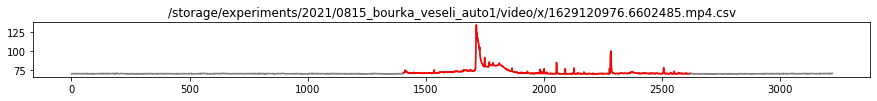

/storage/experiments/2021/0815_bourka_veseli_auto0 5


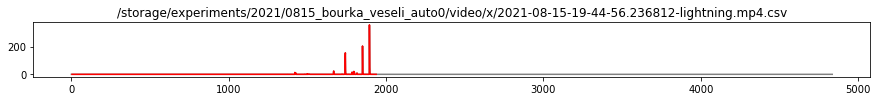

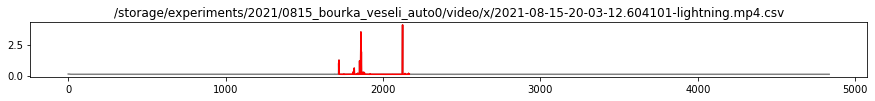

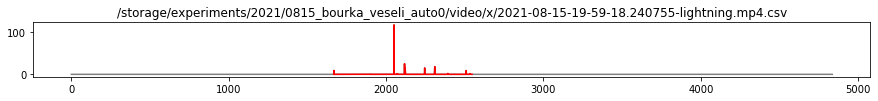

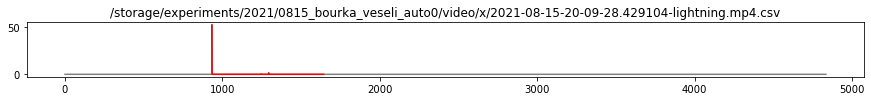

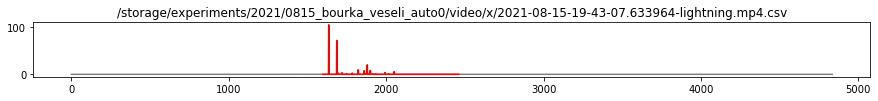

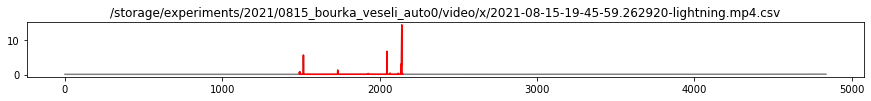

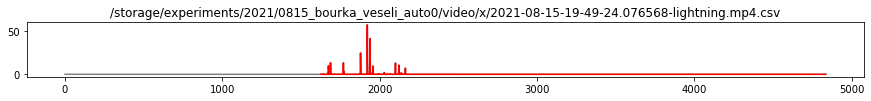

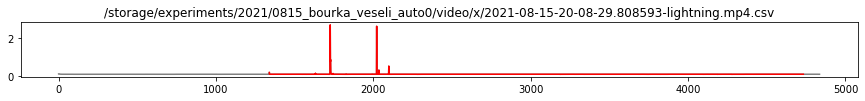

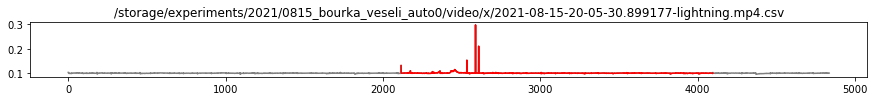

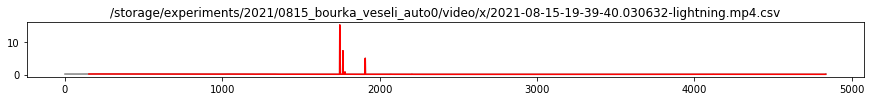

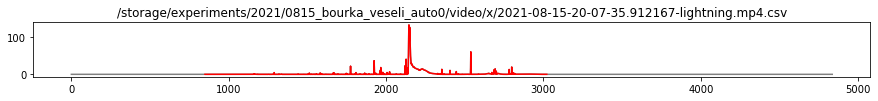

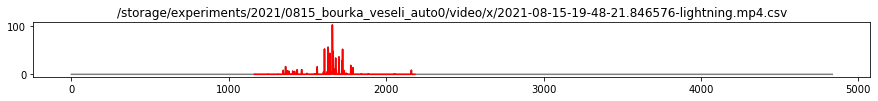

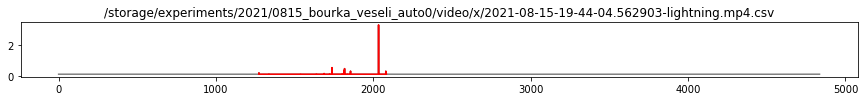

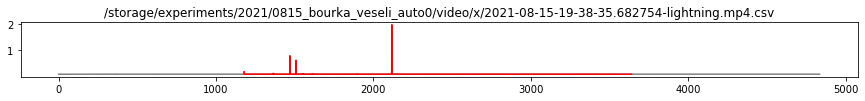

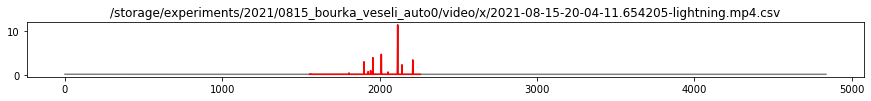

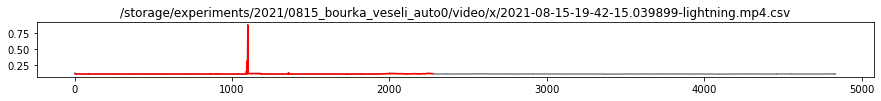

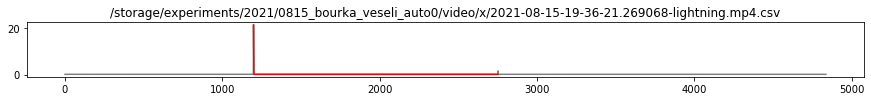

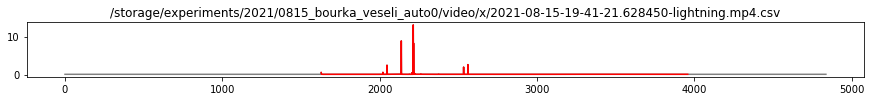

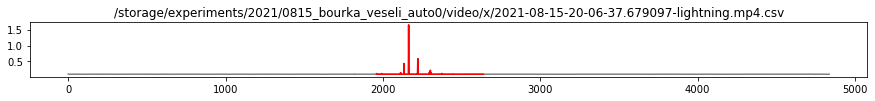

/storage/experiments/2021/0816_bourka_sobeslav 5


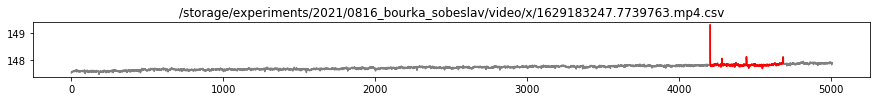

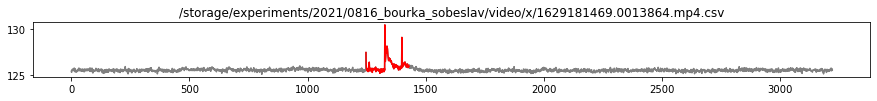

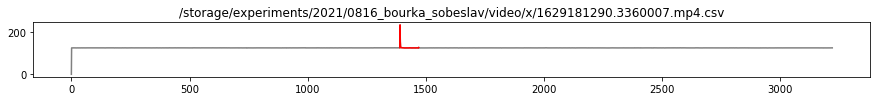

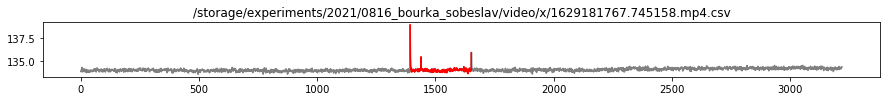

/storage/experiments/2021/0822_bourka_sobeslav_auto0 5


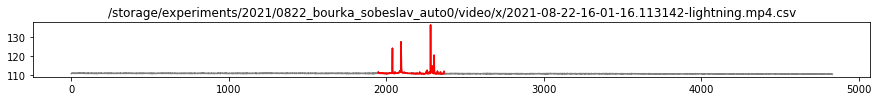

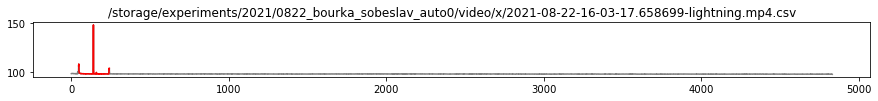

name width height frames  \
0    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14549   
1    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14550   
2    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14550   
3    /storage/experiments/2021/0609_bourka_sobeslav...   800    600   8611   
4    /storage/experiments/2021/0609_bourka_sobeslav...   800    600   8612   
..                                                 ...   ...    ...    ...   
109  /storage/experiments/2021/0816_bourka_sobeslav...     0      0      0   
110  /storage/experiments/2021/0816_bourka_sobeslav...     0      0      0   
111  /storage/experiments/2021/0816_bourka_sobeslav...     0      0      0   
112  /storage/experiments/2021/0822_bourka_sobeslav...     0      0      0   
113  /storage/experiments/2021/0822_bourka_sobeslav...     0      0      0   

     event_end  event_start  
0      10231.0      10061.0  
1       9520.0       8930.0  
2       9732.0       9495.0  
3       4149.0       3076.0  
4       2130.0       1874.0  
..         ...          ...  
109     1430.0       1247.0  
110     1471.0       1390.0  
111     1653.0       1393.0  
112     2368.0       1948.0  
113      242.0         46.0  

[114 rows x 6 columns]

In [30]:
'''
d = [{'dir':"/storage/experiments/2021/0605_bourka_radosovice",'threshold':5},\
{'dir':"/storage/experiments/2021/0711_bourka_stiavnica",'threshold':5}
#"/storage/experiments/2021/0713_bourka_exit29_D8",\
#"/storage/experiments/2021/0609_bourka_sobeslav"]
#"/storage/experiments/2021/0713_bourka_exit29_D8",\ # stroboskopicka bourka, nelze rozlisit jednotlive blesky
    ]
'''
d = [\
{'dir':"/storage/experiments/2021/0605_bourka_radosovice",'threshold':5},\
{'dir':"/storage/experiments/2021/0609_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0711_bourka_stiavnica",'threshold':5},\
{'dir':"/storage/experiments/2021/0714_bourka_martin",'threshold':5},\
{'dir':"/storage/experiments/2021/0714_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0725_bourka_ratmirov",'threshold':5},\
{'dir':"/storage/experiments/2021/0726_bourka_zabori",'threshold':5},\
{'dir':"/storage/experiments/2021/0803_bourka_votice",'threshold':5},\
{'dir':"/storage/experiments/2021/0807_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0815_bourka_veseli_auto1",'threshold':5},\
{'dir':"/storage/experiments/2021/0815_bourka_veseli_auto0",'threshold':5},\
{'dir':"/storage/experiments/2021/0816_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0822_bourka_sobeslav_auto0",'threshold':5}]
#'''

files = pd.DataFrame( columns=['name', 'width', 'height', 'frames'])

window_size = 100
#threshold = 5

for directory in d:
    print(directory['dir'],directory['threshold'])

    for f in glob.iglob(directory['dir'] + "/video/x/*.csv"): # generator, search immediate subdirectories 
        s = f.split('/')
        st = s[len(s)-1]
        ss = f.split('.')
        sss= (ss[0]+'.'+ss[1]).split('/x')
        ff = sss[0]+sss[1]
        
        threshold = directory['threshold'] 
        
        # Import light curve
        light_curve = pd.read_csv(f, names = ['frame','illuminance'], header=0)
        #print(len(light_curve))

        vcap = cv2.VideoCapture(ff)
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        video_length = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        signal_samples=light_curve[["illuminance"]].to_numpy()
        if len(signal_samples) > 0:
            start_sample = signal_samples[:window_size]
            start_noise_std = np.nanstd(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            start_noise_mean = np.nanmean(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            
            end_sample = signal_samples[-window_size:]
            end_noise_std = np.nanstd(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            end_noise_mean = np.nanmean(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            #!!!print(start_noise_std, start_noise_mean, end_noise_std,end_noise_mean)


            for sample_num in range(0,len(signal_samples)):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / start_noise_std
                if z_score > threshold:
                    event_start = sample_num
                    break

            for sample_num in reversed(range(0,len(signal_samples))):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / end_noise_std
                if z_score > threshold:
                    event_end = sample_num
                    break
            try:
                plt.figure(figsize=(15,1))
                #plt.tight_layout()
                plt.plot(signal_samples,c='gray')
                plt.plot(range(event_start,event_end), signal_samples[event_start:event_end],c='red')
                plt.title(f)
                plt.show()
            except:
                pass

        else:
            event_start = float("NaN")
            event_end = float("NaN")
        
        #print(f, ',', int(width), ',', int(height), ',', video_length)
        files = files.append({'name':f, 'width':int(width), 'height':int(height), 'frames':video_length, 'event_start':event_start, 'event_end':event_end}, ignore_index=True)
        vcap.release()
files

/storage/experiments/2021/0605_bourka_radosovice
0.2509224631007462 43.94431251905487 0.22897574758273959 43.936775990853654


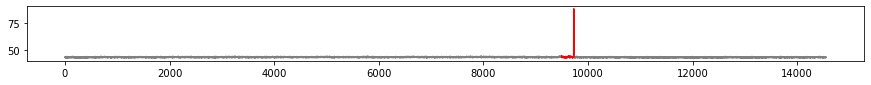

0.15443144230075706 74.18581789253048 0.17643505077538152 73.75351583460365


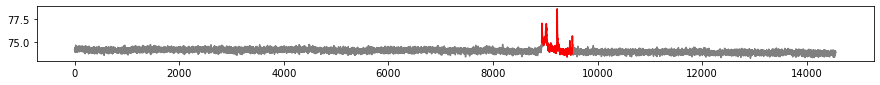

0.2557436538077293 39.13577269435976 2.9416787049894304 30.405500190548782


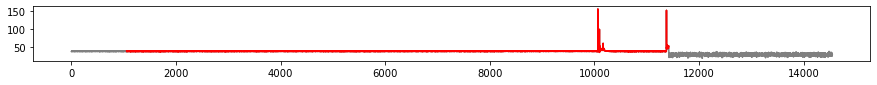

/storage/experiments/2021/0609_bourka_sobeslav
0.04819054142040852 102.02843955493182 0.04987677244135475 102.0171773757017


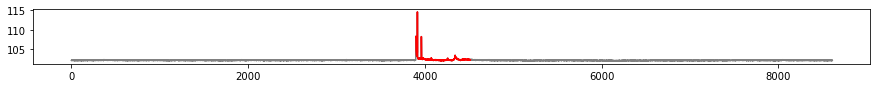

0.05650576651785893 81.82410020298717 0.05793671143919623 81.84695392692461


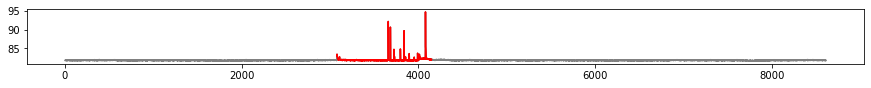

0.06088493582663278 84.8009467346632 0.058905501802629955 84.77946339965918


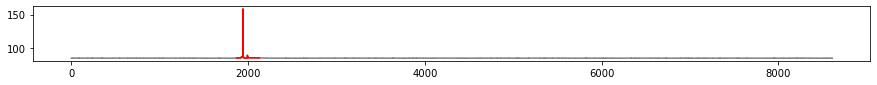

0.050209978629481206 90.91417342872892 0.05331464510002521 90.96548426222935


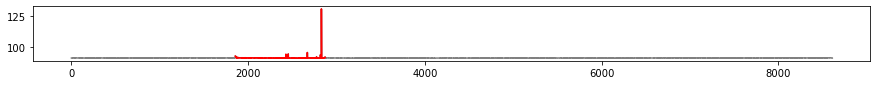

/storage/experiments/2021/0711_bourka_stiavnica
0.19387752897462643 129.18569238672816 0.17051748252280027 127.76385986367282


0.15158489075455425 146.13850497332317 0.12850895468201873 146.0953740472561


0.07581401311067087 254.85557090320123 0.0856855867756522 254.86301537728662


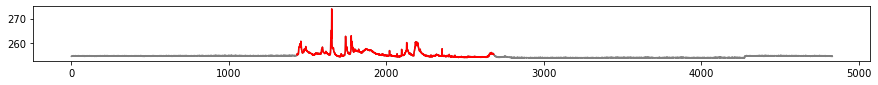

0.1383713534218779 164.94164426448168 0.1618975864520221 160.08730518292683


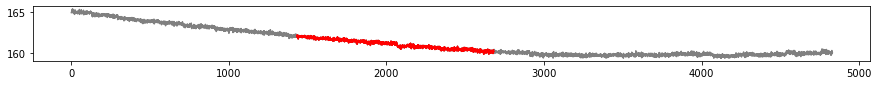

0.17234129154828504 117.28119731326218 0.17174609400134025 117.67822256097561


6.378716249685944 201.76583193597563 0.11886311259533838 188.32372267530485


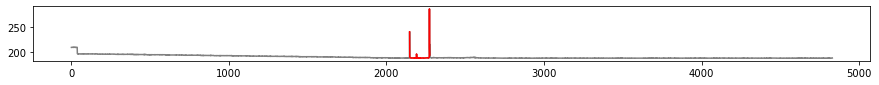

0.09399558684046758 208.96033052591463 0.11659580613650568 208.95281787347562


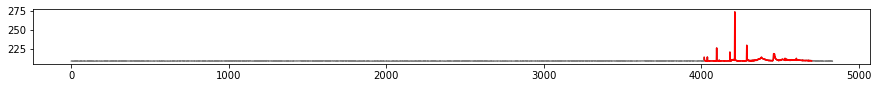

0.14741167294292162 129.46601949314027 0.14781676770731375 129.99039516006098


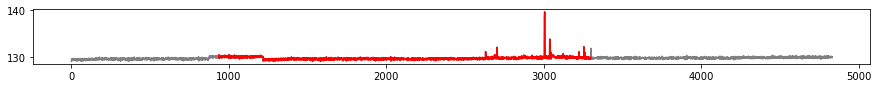

0.11475636786388947 177.08289910442073 0.11701715501620644 177.08641455792684
0.13111564186306865 154.28220038109757 0.12524240662942931 153.79896594893293


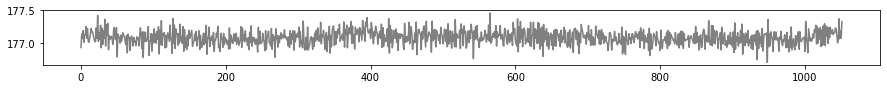

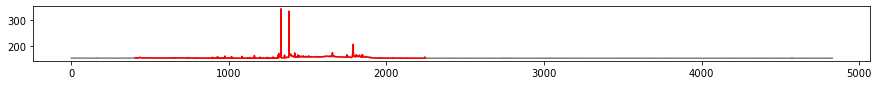

0.08107950157099619 244.04202583841467 0.07841225406650552 243.3240151295732


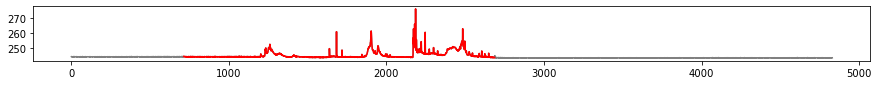

0.08477062762721775 237.3802947217988 0.0845832793674222 237.32442522865855


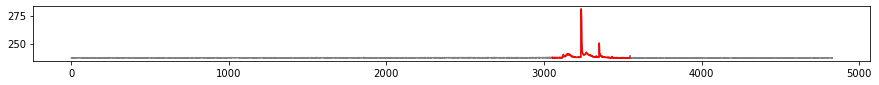

0.07559417946256994 289.83849096798787 0.06362048555299121 289.83201716844513


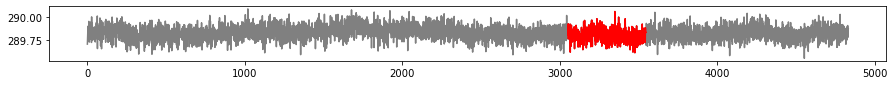

0.06774950475683743 300.51366541539636 0.06758165851346197 300.61691215701217


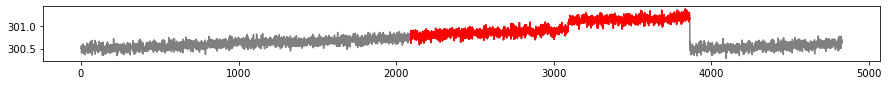

0.11797986517036595 175.2770100800305 0.12207283012385078 175.90471147103653


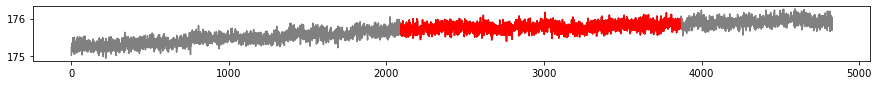

0.1536113625523104 130.0505214557927 0.1456799257560704 129.989969378811


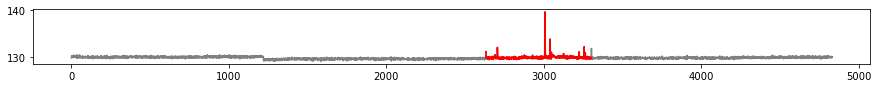

0.13928608398297931 139.9406240472561 0.12415522937080864 139.46528163109758


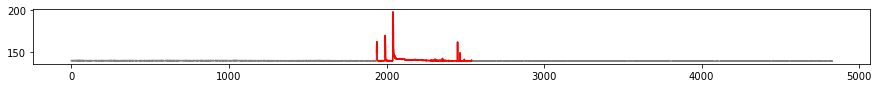

0.08938796214478506 221.39881777820128 0.09129855029081903 221.3701383193598


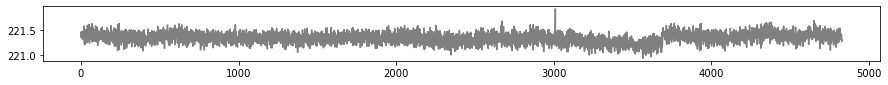

0.18529896037642254 96.30075417301829 0.15833267696735515 96.30577477134146


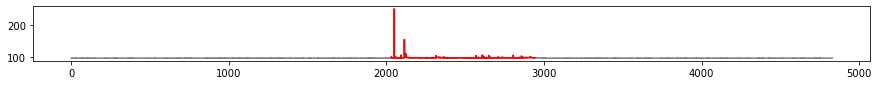

0.12533486683174305 172.28431789253054 0.14192679613180256 169.81566444359757


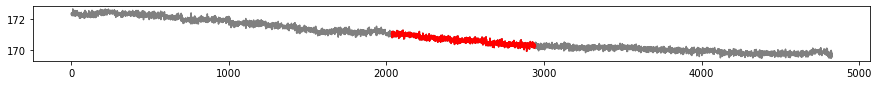

0.8738047744668582 210.16599826600614 0.09093132549836708 209.93884190167685


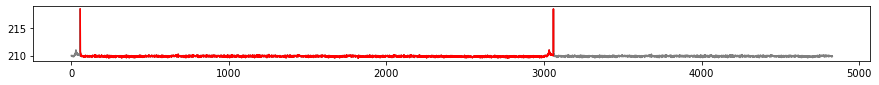

0.11974604710000623 161.37386400533535 0.13013325634215206 160.5819027820122


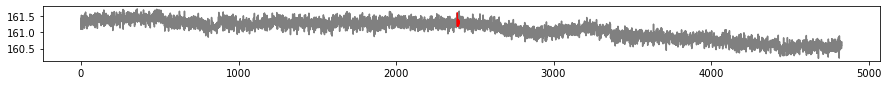

0.12350982689439899 186.06459731326217 0.43705753349176457 186.563399066311


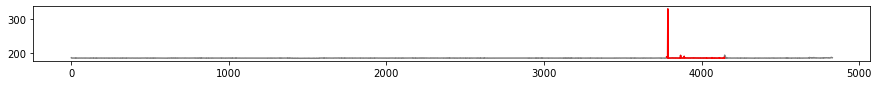

0.08826167714946388 245.96516068978656 0.08846001352514661 245.97036274771344


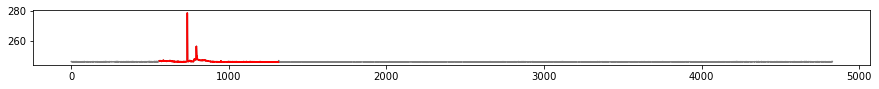

0.10777661621351199 175.71782459984755 0.11586709015483876 174.34422442835367


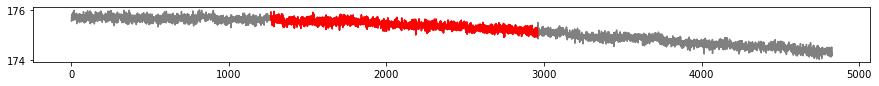

1.417601249798384 230.98065076219515 0.12576599863387922 222.9321599657012


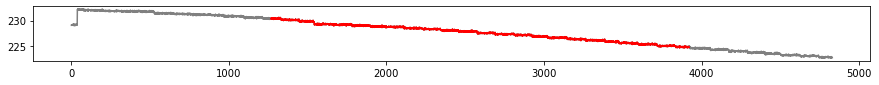

0.0924303580914242 229.1848189596037 0.0899394302924231 229.37950421112805


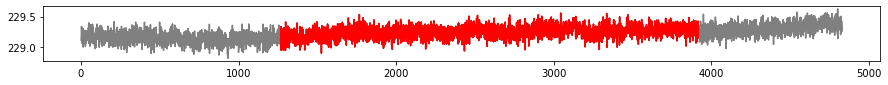

0.12993619462976883 135.79516928353658 16.197940791802875 145.8973363567073


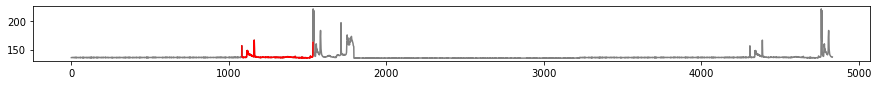

0.06803280273445515 279.5370485327744 0.07744358548925517 279.6699406059451


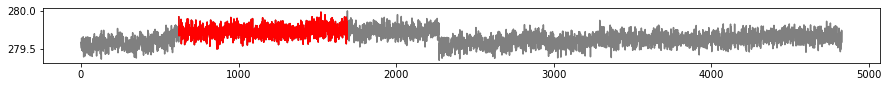

0.09754335141181927 214.64634889481707 0.09670811677411925 214.50768660442074


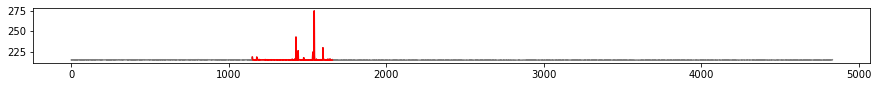

0.13065642877542633 158.42906025152436 0.12777021864635146 158.44291015625


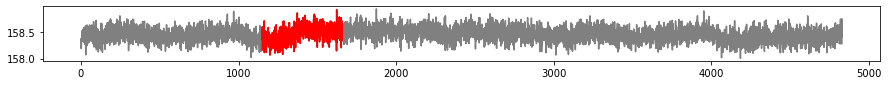

7.91437450824321 275.1598590129573 0.08153135413913541 279.5837932164634


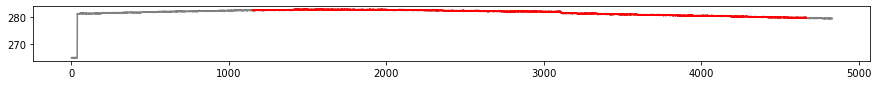

0.12618218663379718 150.57439721798778 0.13369603426788298 150.07715160060977


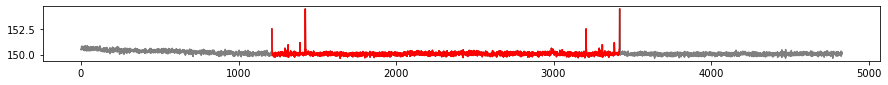

0.12156148068283215 173.48328940548777 0.12254682930302291 175.3868700457317


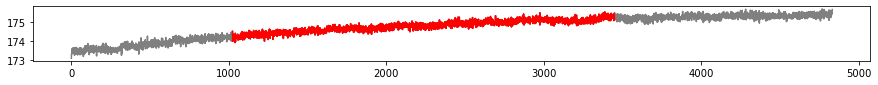

0.08394123409212075 231.9540738757622 0.09256030370659517 231.27824910442075


0.27463199626979656 204.7094577172256 0.6633454633567394 205.34204956173784


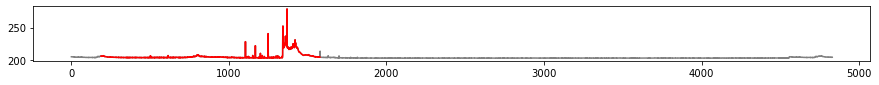

0.07953284474577843 265.01519493140245 0.07683899141117304 265.16008031631094


0.07606829693457115 258.0876427972561 0.08017960640460388 257.6384855945122


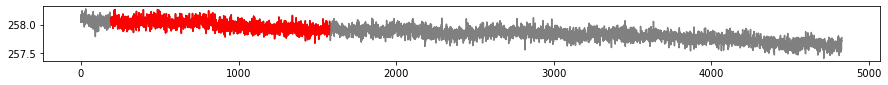

0.07494915368253371 254.90160518292686 0.08305210011581232 254.86025487804875


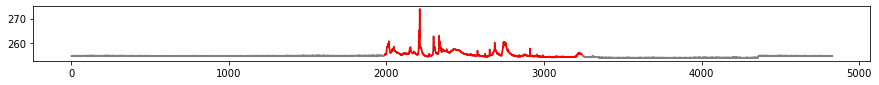

0.1352173567165178 173.46747841082322 0.15385990197138882 165.83576280487804


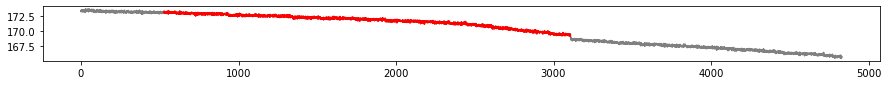

/storage/experiments/2021/0714_bourka_martin
0.14199621100455878 195.86410094226142 0.12066263692782007 195.81597422564153


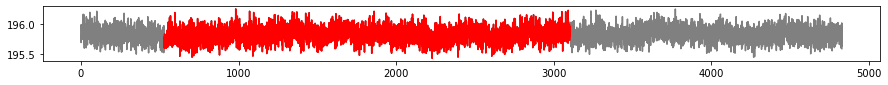

0.07452716305670035 370.31557479200075 0.0592767000200127 370.27119945368884
0.16041634158557497 142.26840978348037 0.15797722727767222 143.36378856756212


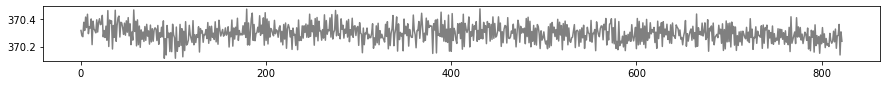

0.17733975711190317 124.54712051423414 0.1760613644309641 124.08739105102248


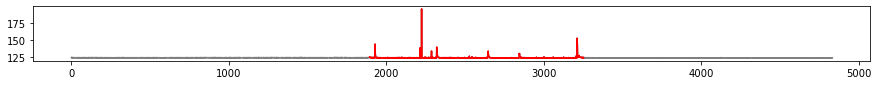

0.23758840905484646 91.23398214464714 0.23622379422565978 90.9187127230353


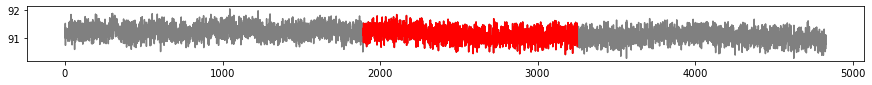

0.10773184172504195 229.28445743534476 0.10976896878836437 229.012163367081


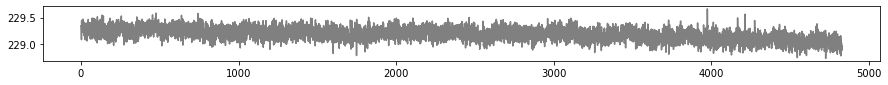

0.15492338102554293 152.88268805132316 0.1582799530799756 152.39299844627104


0.10773184172504195 229.28445743534476 0.11107892328673424 229.0107558640738


0.1518500443809319 348.35945913943453 0.1494617816202816 347.94280745038094


0.07233230680261796 370.31334091820366 0.06725944975418169 370.08867599739364


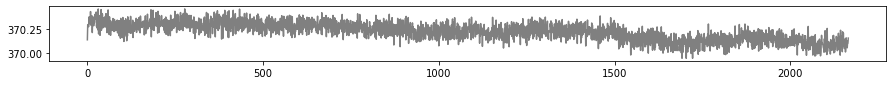

0.1388788897308887 176.5495483660786 0.14408431112827033 176.7464050721732


0.206734311109027 113.33657629560946 0.1999763308950534 113.4087282477947


/storage/experiments/2021/0714_bourka_sobeslav
0.21714987373197656 111.5321420922256 0.22873207264126327 111.88681006097559


0.10732250263069375 95.21307633384146 0.10051765225836001 96.06228332698169


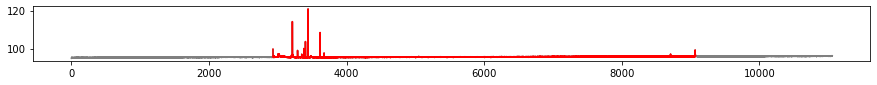

0.2182118975792649 112.6564861280488 0.22667492016273053 112.52303443216462
0.22868521904117706 116.2873880144817 0.22919417756264066 116.17306960746951


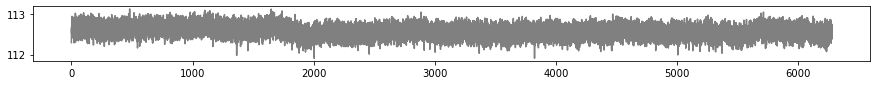

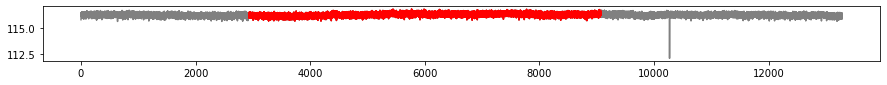

0.21334601043407012 111.97937852515241 0.22570640089954846 111.76140297256097


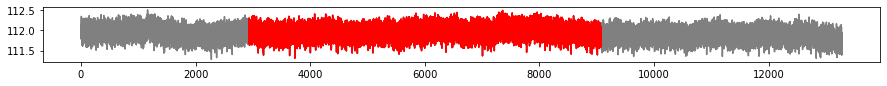

/storage/experiments/2021/0725_bourka_ratmirov
0.0038943832442748464 0.13237477445870088 0.001389350522735946 0.13040008520449076


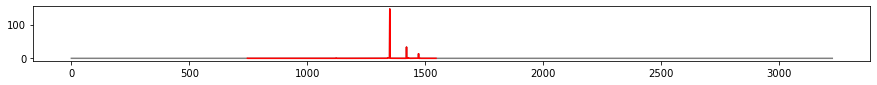

0.0041449417170351536 0.1300699303327987 0.0006130027091655941 0.1275724739374499


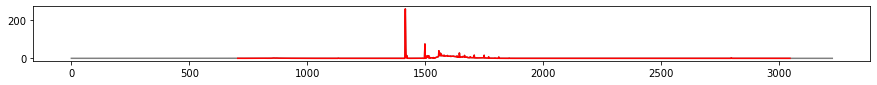

0.027976085529142353 2.7977271576784277 0.016859339602650708 2.680843311447474


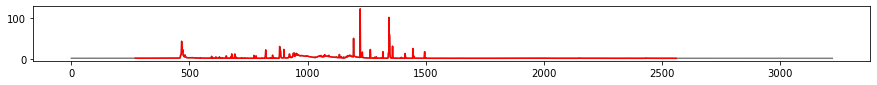

0.01783547614533439 0.3399764434643144 0.005705184188111435 0.32389042451884525


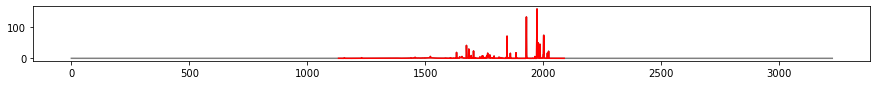

0.028840285960556346 1.4717338111467522 0.008248068112532838 1.3773089539895746


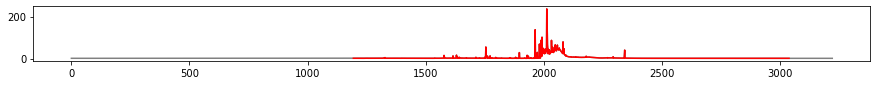

0.018496887556974408 0.4323443639735365 0.006679835765472129 0.42805471882518037


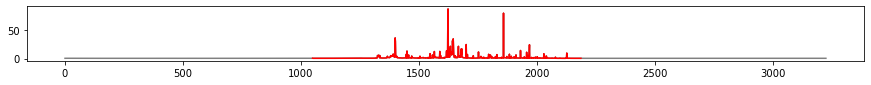

0.012565566978725882 0.26846395098235765 0.005144340121531872 0.2639197824779471


0.018968813177726817 0.832243634723336 0.010120147074465399 0.8255493810144346


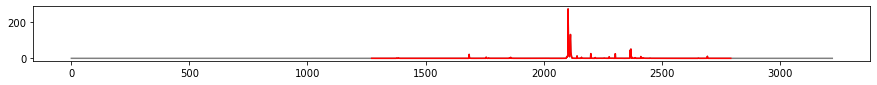

0.014795587778218829 1.4889241178829193 0.00909253352820568 1.4925493935445067


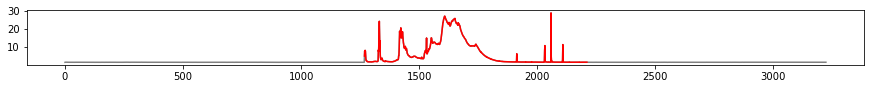

0.0328738792074357 2.1414534758420207 0.014027724528618021 2.07242648606656


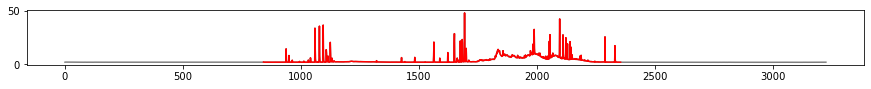

0.004126986606423694 0.1402651488572574 0.0032620662221746004 0.13898580342822775


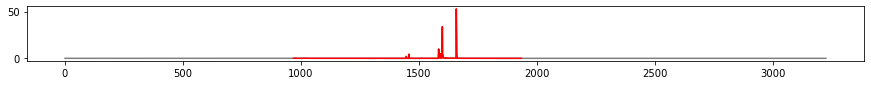

0.01148725162497259 0.4325299844627104 0.004396877926080673 0.42398012730553325


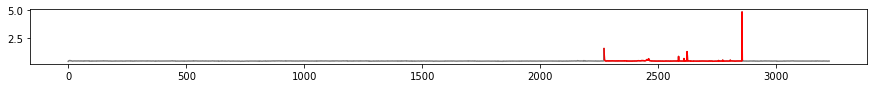

0.009056266389339169 0.1397431711106656 0.002499794339941414 0.1339289419607057


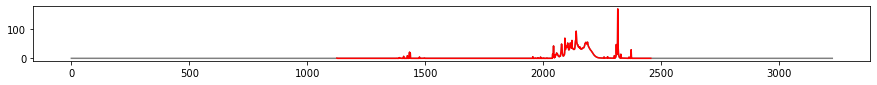

0.017072387747492285 0.6357519045709703 0.008208456879577716 0.635763745489174


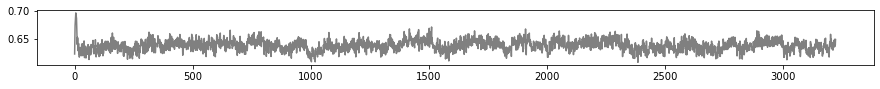

0.021762571376937507 1.0337766639935846 0.01104423000425023 1.0176082472935044
0.01757428091989031 0.4925757317562149 0.006521247800007655 0.4927045534282278


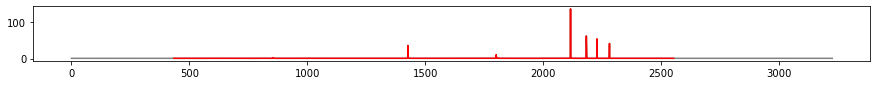

0.004402382995100342 0.1299977947072975 0.0005341857029919037 0.1275864950882117


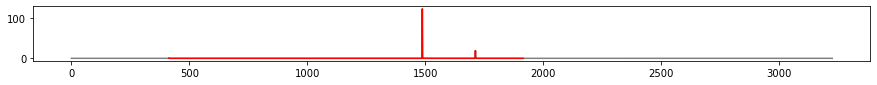

0.02353683642596153 1.1884952511026463 0.010167637254804856 1.1755987244386528


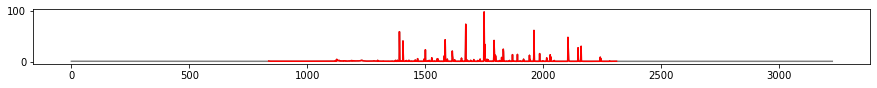

0.020947448733456282 1.699709339915798 0.012101314800253391 1.6184211733159584


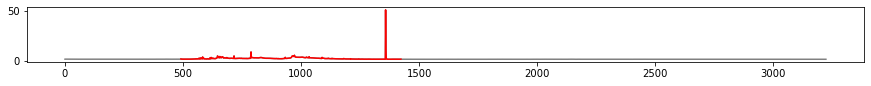

0.0042133399466562456 0.12995396451483562 0.0005387195084339524 0.12722506515637527


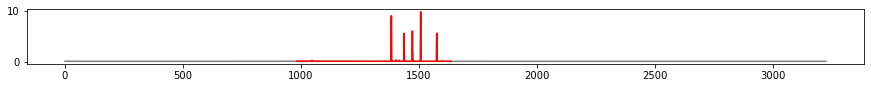

/storage/experiments/2021/0726_bourka_zabori
0.09813190877540073 62.06935965066159 0.06560938330823124 61.786054443163586


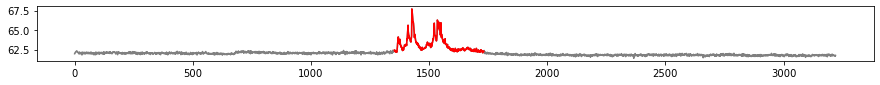

0.06026306913073648 126.20915718975543 0.04531652084950512 125.95920991629912


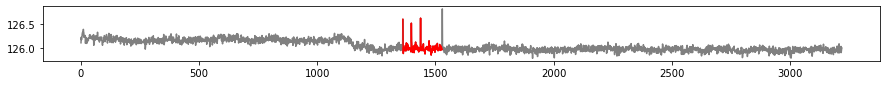

0.07496037289555033 82.12718966770248 0.11882093364167023 71.70203167602246


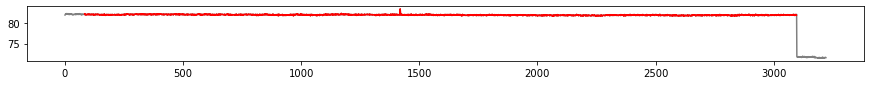

0.08343723249922544 60.41843049568966 0.10152974553639657 60.43782467923015


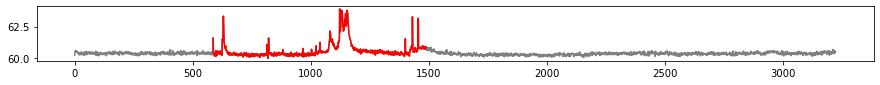

0.0488885344234426 152.26747768394148 0.04096213087686627 152.16898721932637


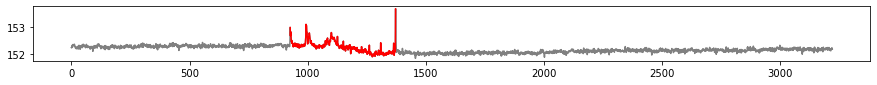

0.06076058881863887 115.54901196621891 0.06521556642171077 115.4145871341219


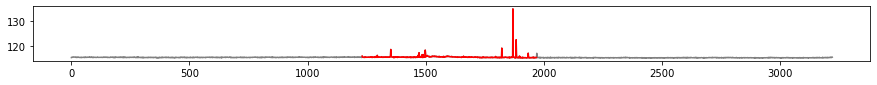

0.06249624970947282 87.09065504711307 0.06962780991373693 87.18332590717722


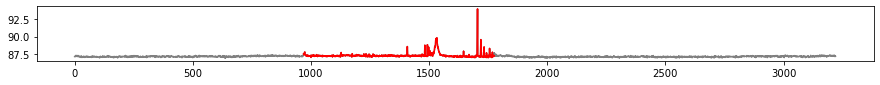

/storage/experiments/2021/0803_bourka_votice
0.04553885508046445 191.14574263231756 0.0357553178610524 191.001366842923


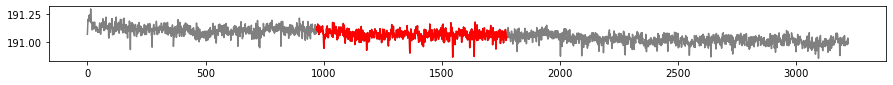

0.04415639276742054 203.26292314053728 0.037619988820207693 203.14429875451086


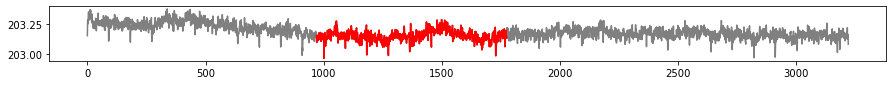

0.04115358328292137 206.59629058490376 0.03445450975177081 206.55238239274257


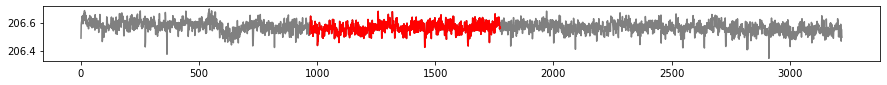

0.07115098373379664 124.39956514384522 0.059906805372466634 124.54486061547713


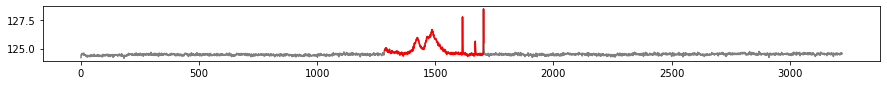

0.06512685790280447 86.53241689144856 0.05982791302030736 86.64770129560947


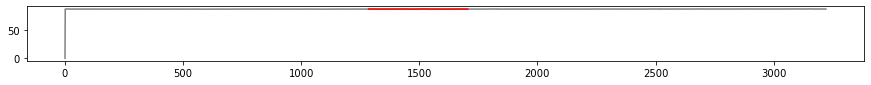

0.07316915987277144 201.4485697298516 0.04849046774921306 201.4871654094828


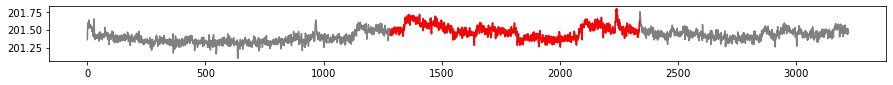

0.0614700819340115 169.13600145348835 0.048810631664353794 169.27265685144343


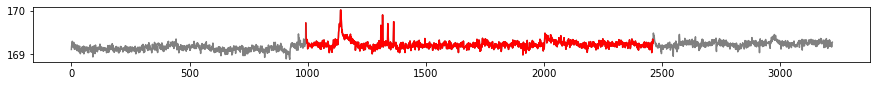

0.06129696849462965 157.62309844877703 0.0456929836285356 156.91156771251002


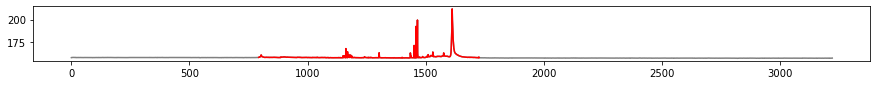

/storage/experiments/2021/0807_bourka_sobeslav
0.0610542058475624 189.82497173215717 0.06367031500977743 189.74794310094225


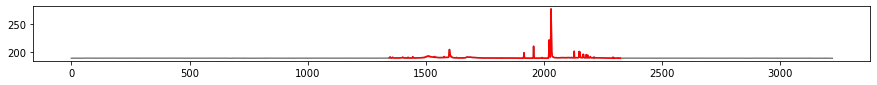

0.06586264377469721 190.0361975867081 0.060942298746115925 190.0075311748196


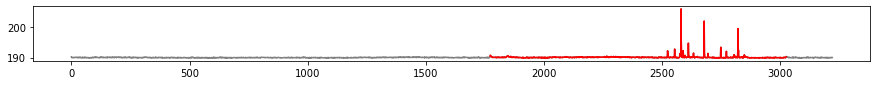

0.06669301680824762 190.06019589514835 0.06188605414182477 190.04920132066968


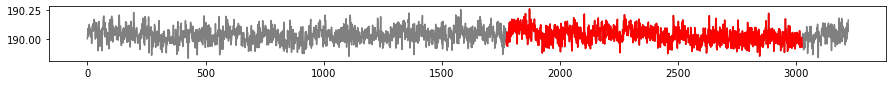

0.006988300379982109 0.1382998947473938 0.0006166865775130393 0.13425928478348034


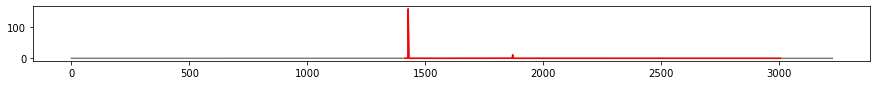

0.07416774671542138 190.1011265286688 0.05843851807763904 190.07994609562954


0.05334623905048552 189.7881036612871 0.07446922437947076 189.75730693664795


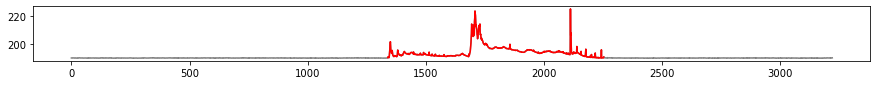

0.00255735364346502 0.13344417852846832 0.0011932586228508351 0.13066765236567762


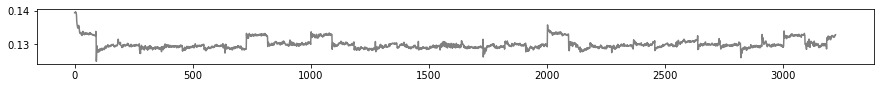

0.06953555045250585 189.97841232708504 0.3130443300001326 189.4176009923817


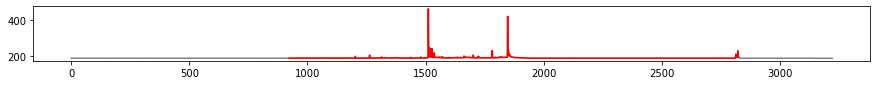

0.058923360019571436 190.0559288793103 0.06456162087731719 190.0168468574579


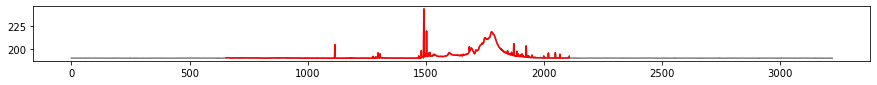

0.06078012822067024 189.59066740176434 0.15457857745360198 189.65434951383315


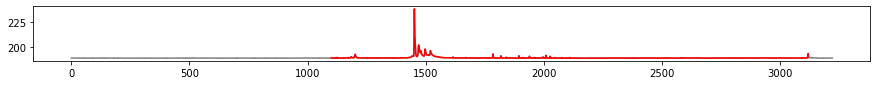

0.005389406297407589 0.13901065056134723 0.0003418571990207489 0.13361581545709703


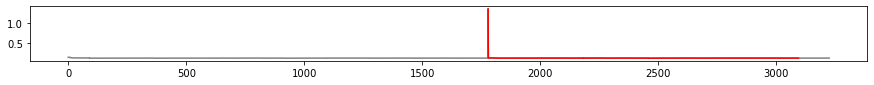

0.06050824667964266 190.01491505864072 0.13218082092294656 190.13784807287485


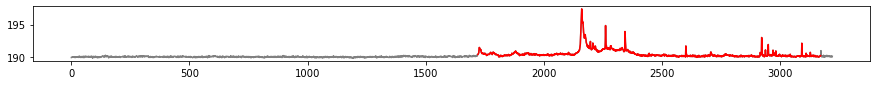

0.002377413414748182 0.1396811096631917 0.001715108905415853 0.1351186723135525


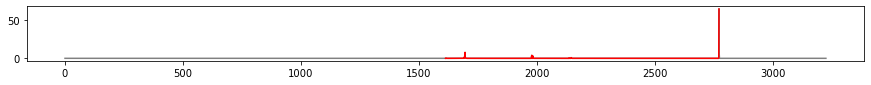

0.056035211431479895 190.08711304631115 0.05792029018564545 190.00910274659182


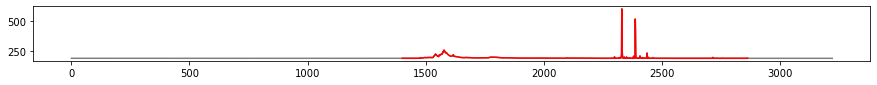

0.06293222153355417 189.6938315331796 0.06399231679287166 189.78305307738566


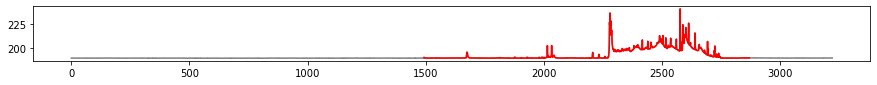

0.05991183245835681 189.9282189755413 0.05920136177434013 189.94806672263437


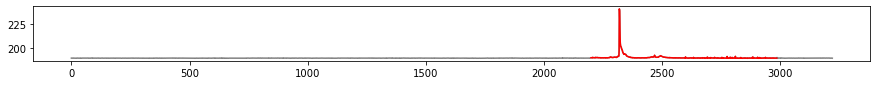

0.07248927536746791 190.18694848887333 0.18120807066188696 190.23857113321975


0.07489685882941881 189.724948263332 0.062142432631808596 189.68027541098635


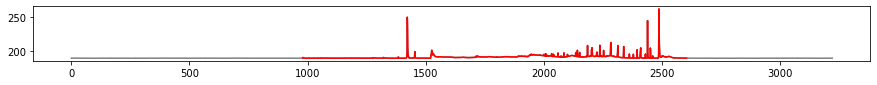

0.056046203588253976 189.7207916875501 0.05723774261677146 189.68408540497188


0.0065920822904926195 0.13694266238973538 0.0005602326419495519 0.13273541499599037


1.5800884378630862 191.77866722634323 0.2253305527955381 190.18762394747395


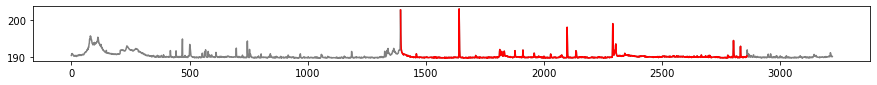

0.005526367552450247 0.13895107006816362 0.00035204978558031066 0.13426289344426623


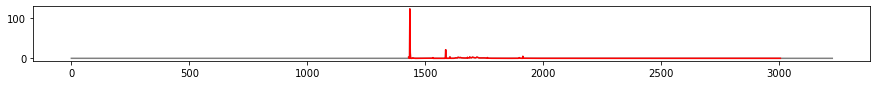

0.0007884826221057953 0.13310146852445873 0.0007697097091893344 0.13172641840417001


/storage/experiments/2021/0815_bourka_veseli_auto1
0.16696990787976504 90.09942946822378 0.1441784241272234 90.00131625902164


0.16752327461537458 76.45864275511227 0.15961498333563376 76.60884976443464


0.1546848103831687 97.97262427325582 0.13570929355813224 98.11727605002005


0.18584992829439434 70.80969820068164 0.1773734748289485 70.91806042000802


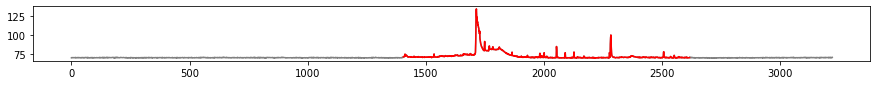

0.1567402755131846 98.22553023506414 0.1549294778853215 98.02908071872493


0.18867030757405112 86.08172596732157 0.24252831727240887 86.25034203338011


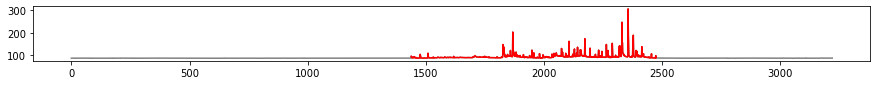

0.14688592760112068 88.24076177826787 0.16120635817277346 88.41574607808741


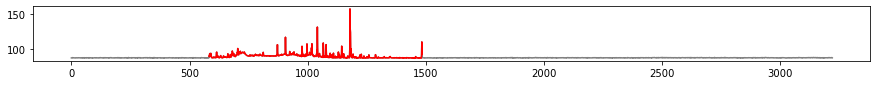

0.18736810588003616 93.36887670408981 0.1496968414540866 93.11152182738572


0.17303830722210942 92.94125096481557 0.16783954873225265 92.91902578688855


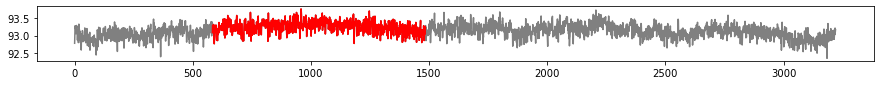

0.14334533469567415 98.41040463362071 0.133318113925434 98.31015637530072


0.16739707548668215 91.382610414996 0.14879777197195498 91.47595135825982


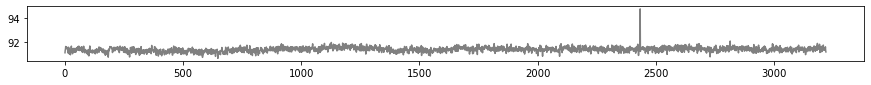

0.1870800667220552 84.46302433340018 0.15266448870999755 84.29664458450279


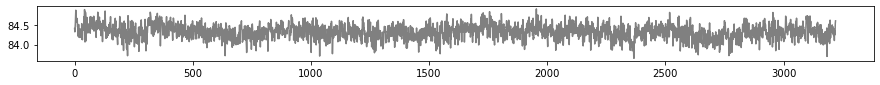

0.16535864964980634 90.72420093223737 0.1540521626513604 90.67432777415797


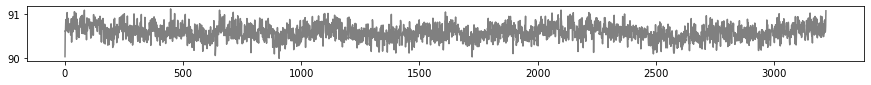

0.1486381348518582 89.16193864023654 0.17429643233494038 89.12480461858462


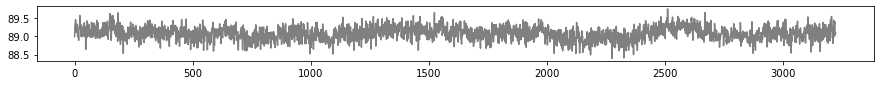

2.667026400928331 84.25147174468724 0.1750511388035761 83.03436785785887


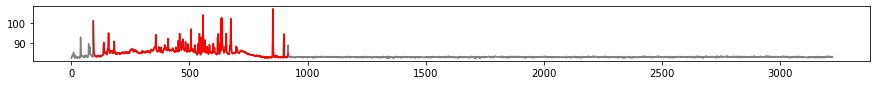

0.15067387492128978 98.59260539043704 0.13377351472556384 98.46718010725745


0.16366872880827343 98.58398636728148 0.13776932120282606 98.34844336407377


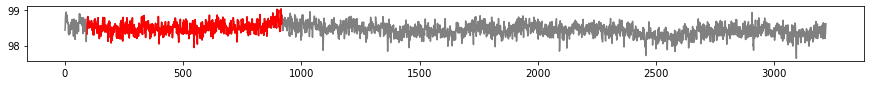

0.17695834829585141 96.80950941008419 0.13122719103991692 96.74822980152368


0.15873282176622358 94.27046071822373 0.14142518979976876 94.30641279069766


0.1644451826058847 90.7904162865878 0.15204796336497223 91.04489122644345


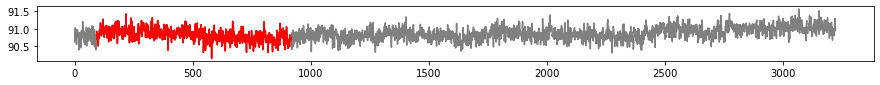

0.20261558043275466 80.34140410735765 0.1693227757116881 80.24903667552125


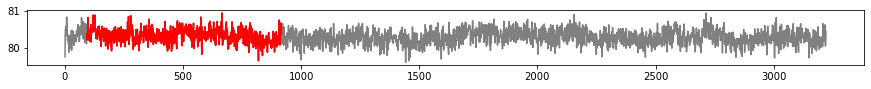

0.16852883166782437 87.79573985064155 0.15855709735766121 87.59556657227344


/storage/experiments/2021/0815_bourka_veseli_auto0
0.0020811309044213256 0.10245996641940659 0.0007363533000397563 0.10227577435846032


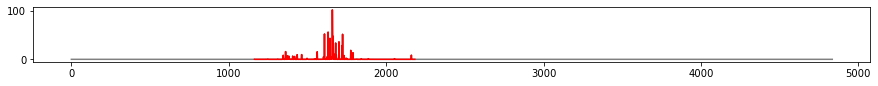

0.0018112736242345262 0.10529116128708903 0.0005372682657141011 0.10525716720128306


0.006675239542525063 0.12291639935846031 0.002050210931977059 0.10201892040898157


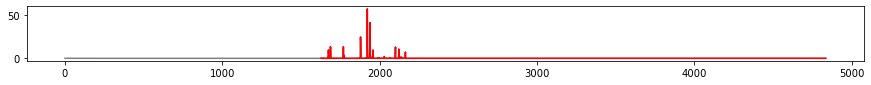

0.0015254004745638861 0.10361954941860464 0.0004909647542025463 0.10365304230152368


0.002785552895199076 0.10373944967923016 0.00573543483751362 0.1575881490577386


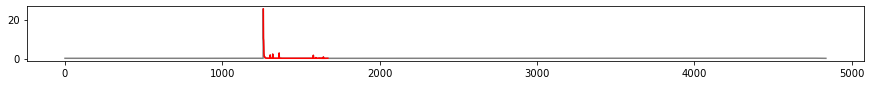

0.004420821030189438 0.10286056535685645 0.0004204803041516074 0.10059329891740176


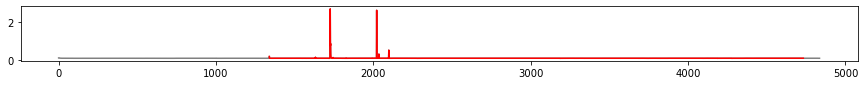

0.0041931678618188865 0.10667747594226144 0.0007395797643715822 0.10057897704490777


0.0008700163679774007 0.10022689454691261 0.0005557006882175433 0.10027615026062549


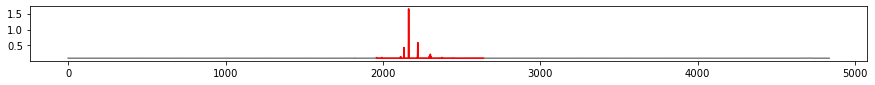

0.0021474529001410383 0.10496443965517244 0.0007040549096821699 0.10184821070569368


0.0028000765827779933 0.10133581846431435 0.0005029970524537597 0.1002153418203689


0.002300533713340216 0.11004320368885326 0.0007963488232232479 0.1051878257818765


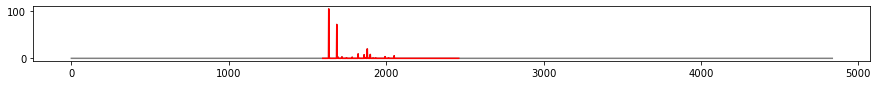

0.0035306981503245606 0.10226310645549319 0.00044056262526186206 0.1010374273255814


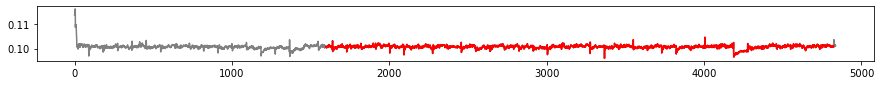

0.0020405343406794322 0.1918222859863673 0.008326441378489388 0.11239642642341618


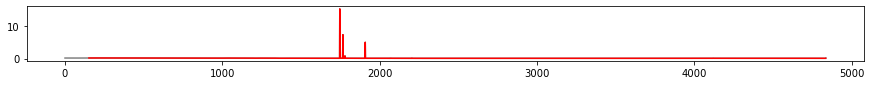

0.005019764053027799 0.10422906224939857 0.0008537621994355654 0.10230321521651967


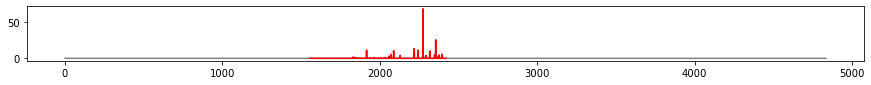

0.005992254950437108 0.1026241103648757 0.0005100172476370514 0.10070886377305534


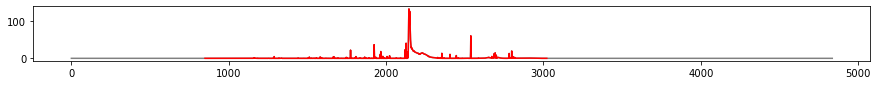

0.005539600532913979 0.10230029570970331 0.0005415568076711241 0.10034996491579791


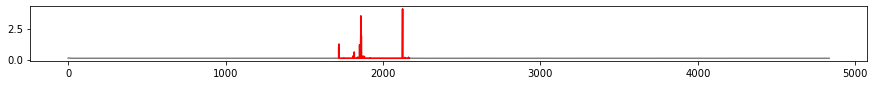

0.003664022562337167 0.10289529871692063 0.0008586788600251449 0.10136008921411385


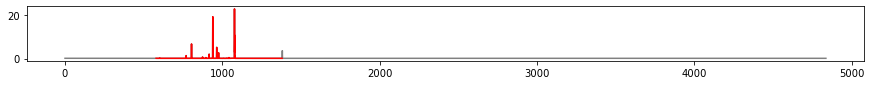

0.0014474985623790975 0.1027938427225341 0.0007537303641597642 0.14401102646351244


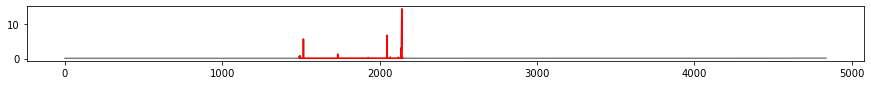

0.0021236641561250638 0.11124354701283078 0.0010033336251225086 0.1112785435044106


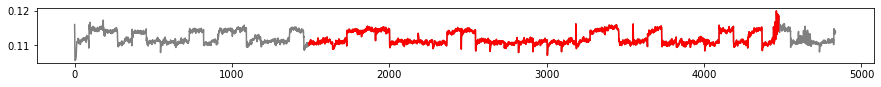

0.005154747993484999 0.10296005412991178 0.0004461430612065875 0.10068837710505213


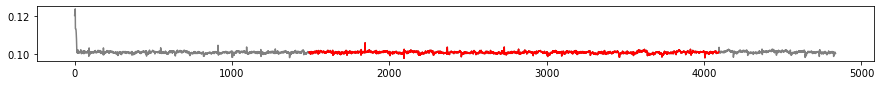

0.0009224896875879593 0.10017761377305533 0.0022561897375983 0.116278355553328


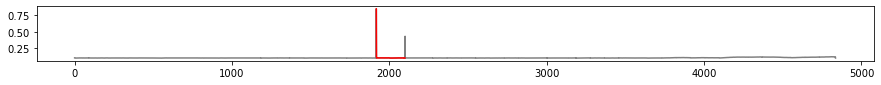

0.0017988394027129832 0.1035687149157979 0.0005727973977197347 0.10335540296712109


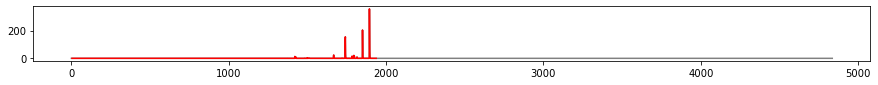

0.0017188914267430183 0.10422577937048919 0.0007423703000625069 0.10453984562951084


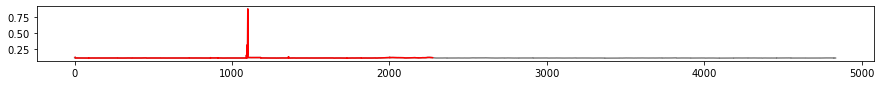

0.0018863176246980509 0.1045382167201283 0.0006484550157573832 0.10496180834001603


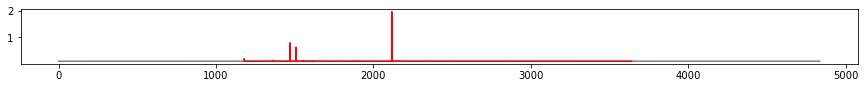

0.00255244362226022 0.10140216519647151 0.0004542134460605855 0.10065103748997595


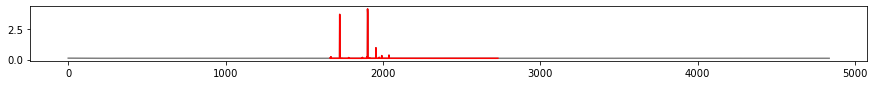

0.001952937633214535 0.10189715316760227 0.0004364594432082247 0.10195623245789895


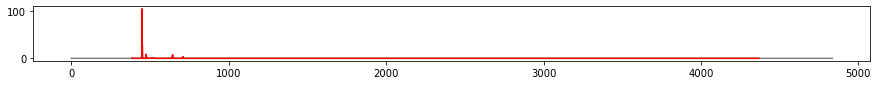

0.002095832267055399 0.10398904871692059 0.000622574752379136 0.10445005513231756


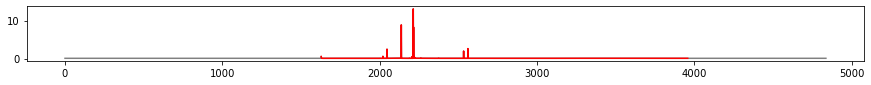

0.0009351015421228588 0.10041520900160386 0.00047269669805271604 0.09993826433440259


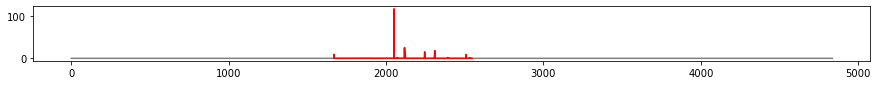

0.0028362957400324376 0.10229390537289493 0.0006370371763200005 0.10117260174418603


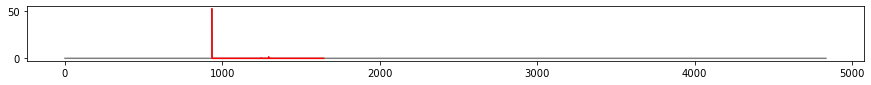

0.0009387969333580219 0.10050007518043305 0.0004526736541546767 0.1003460430032077


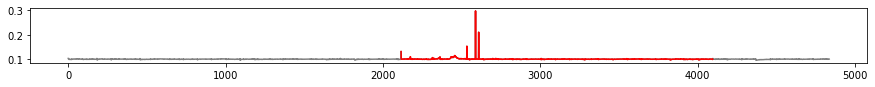

0.0017848287637970111 0.11263149057738571 0.001272205253256637 0.11297307287489979


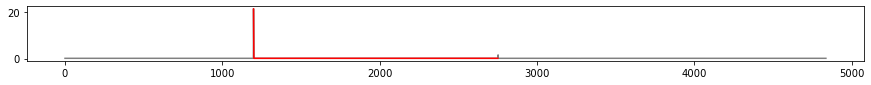

0.0041931678618188865 0.10667747594226144 0.0007395797643715822 0.10057897704490777


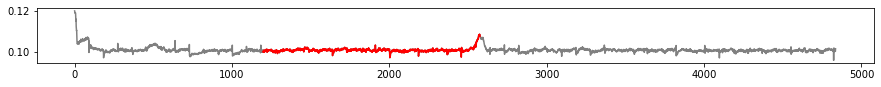

0.005639933729740327 0.19392418053327987 0.009710872324125694 0.2680160886126704


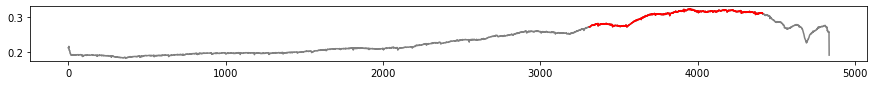

/storage/experiments/2021/0816_bourka_sobeslav
0.11320208466988066 134.04710432538093 0.11023738085463546 134.25232976643943


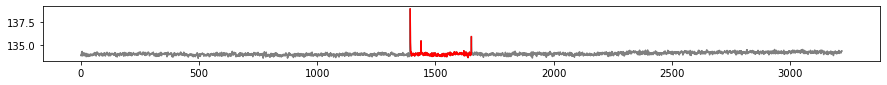

0.12711685012734367 126.06255460073874 0.13124430281021238 126.01598072874899


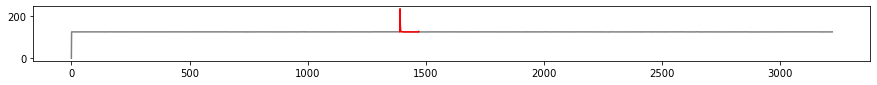

0.09634853787049277 162.44474984963915 0.0755963490379963 162.84685679380516


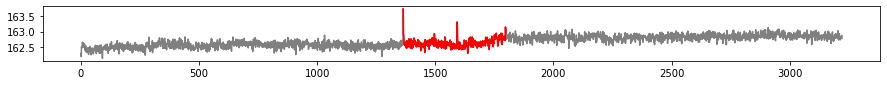

0.038570017233344266 73.17715428277867 0.03944271846800126 73.15431848937449


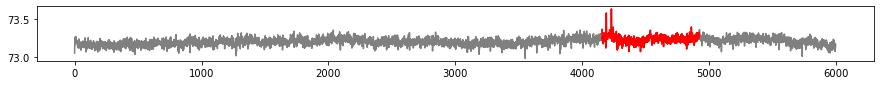

0.11340310201921427 125.56293859011629 0.10360669401671317 125.54643415447073


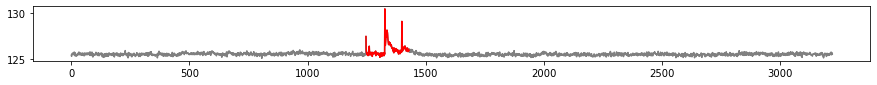

0.021859595259539517 147.59107025611468 0.02615431314565729 147.87061050270648


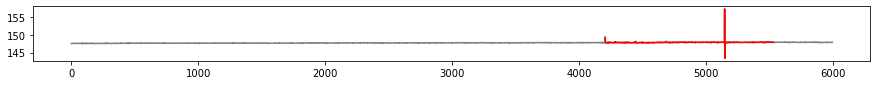

0.10409058543843429 147.47006167301524 0.10060873369816409 147.47542887931036
0.12221543164817746 124.38129648656779 0.09742653093492214 124.4368744486768
/storage/experiments/2021/0822_bourka_sobeslav_auto0
0.06084252675045143 111.01777818013232 0.05531768011434338 110.61631161036489


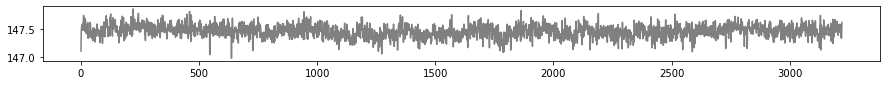

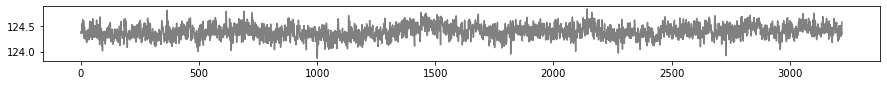

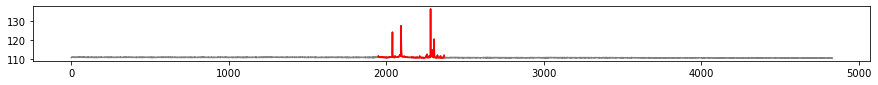

3.2662085071234466 97.52447701984762 0.11780749161146617 112.24022898706895


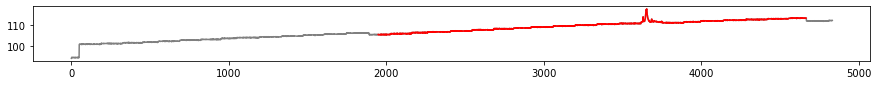

1.3119636805540644 98.83982971631919 0.06640884664204426 98.05413244286287


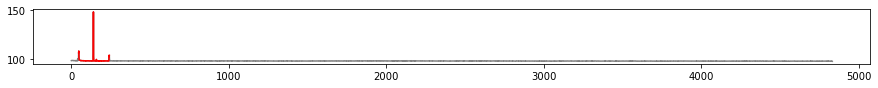

0.05758547080057868 131.51385670609463 0.051456229037727536 130.35932700982357


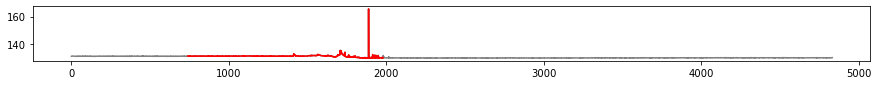

0.0554121566086176 127.2912698977546 0.05800941177822733 125.20572917502005


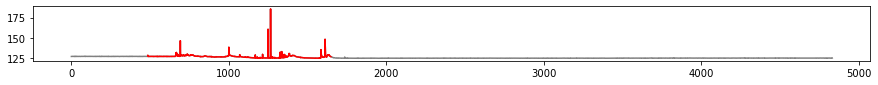

0.07337628954309958 94.25226009923816 0.06940535879611338 94.30583890086207


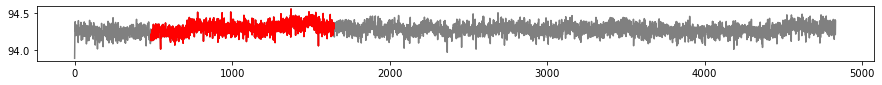

0.05794618841831935 115.35836392341618 0.051393770270491815 114.26197017842821


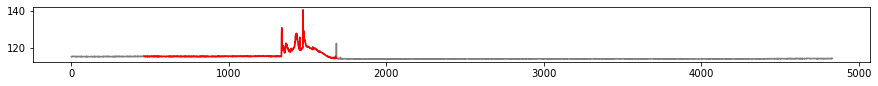

0.05950263860010214 71.08019356455492 0.05426106266140727 71.009473611668


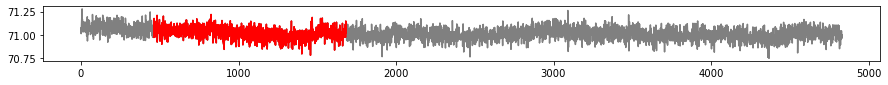

0.05254624764558283 128.63934853648757 0.054431711727295606 128.5180844150962


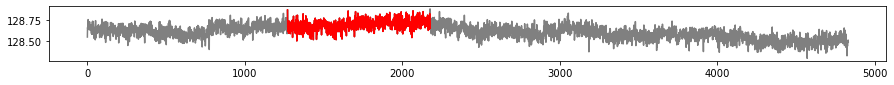

name width height frames  \
0    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14550   
1    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14550   
2    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14549   
3    /storage/experiments/2021/0609_bourka_sobeslav...   800    600   8612   
4    /storage/experiments/2021/0609_bourka_sobeslav...   800    600   8611   
..                                                 ...   ...    ...    ...   
191  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4832   
192  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4833   
193  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4832   
194  /storage/experiments/2021/0822_bourka_sobeslav...     0      0      0   
195  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4833   

     event_end  event_start  
0       9732.0       9495.0  
1       9520.0       8930.0  
2      11421.0       1055.0  
3       4516.0       3898.0  
4       4149.0       3076.0  
..         ...          ...  
191     1649.0        485.0  
192     1683.0        462.0  
193     1683.0        462.0  
194        NaN          NaN  
195     2176.0       1271.0  

[196 rows x 6 columns]

In [2]:
'''
d = ["/storage/experiments/2021/0605_bourka_radosovice",\
"/storage/experiments/2021/0711_bourka_stiavnica",\
"/storage/experiments/2021/0713_bourka_exit29_D8",\
"/storage/experiments/2021/0609_bourka_sobeslav"]
#"/storage/experiments/2021/0713_bourka_exit29_D8",\ # stroboskopicka bourka, nelze rozlisit jednotlive blesky

'''
d = ["/storage/experiments/2021/0605_bourka_radosovice",\
"/storage/experiments/2021/0609_bourka_sobeslav",\
"/storage/experiments/2021/0711_bourka_stiavnica",\
"/storage/experiments/2021/0714_bourka_martin",\
"/storage/experiments/2021/0714_bourka_sobeslav",\
"/storage/experiments/2021/0725_bourka_ratmirov",\
"/storage/experiments/2021/0726_bourka_zabori",\
"/storage/experiments/2021/0803_bourka_votice",\
"/storage/experiments/2021/0807_bourka_sobeslav",\
"/storage/experiments/2021/0815_bourka_veseli_auto1",\
"/storage/experiments/2021/0815_bourka_veseli_auto0",\
"/storage/experiments/2021/0816_bourka_sobeslav",\
"/storage/experiments/2021/0822_bourka_sobeslav_auto0"]
#'''

files = pd.DataFrame( columns=['name', 'width', 'height', 'frames'])

window_size = 100
threshold = 5

for directory in d:
    print(directory)

    for f in glob.iglob(directory + "/video/*.mp4"): # generator, search immediate subdirectories 
        s = f.split('/')
        st = s[len(s)-1]
        
        # Import light curve
        light_curve = pd.read_csv(f+'.csv', names = ['frame','illuminance'], header=0)
        #print(len(light_curve))

        vcap = cv2.VideoCapture(f)
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        video_length = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        signal_samples=light_curve[["illuminance"]].to_numpy()
        if len(signal_samples) > 0:
            start_sample = signal_samples[:window_size]
            start_noise_std = np.nanstd(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            start_noise_mean = np.nanmean(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            
            end_sample = signal_samples[-window_size:]
            end_noise_std = np.nanstd(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            end_noise_mean = np.nanmean(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            print(start_noise_std, start_noise_mean, end_noise_std,end_noise_mean)


            for sample_num in range(0,len(signal_samples)):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / start_noise_std
                if z_score > threshold:
                    event_start = sample_num
                    break

            for sample_num in reversed(range(0,len(signal_samples))):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / end_noise_std
                if z_score > threshold:
                    event_end = sample_num
                    break
            try:
                plt.figure(figsize=(15,1))
                plt.tight_layout()
                plt.plot(signal_samples,c='gray')
                plt.plot(range(event_start,event_end), signal_samples[event_start:event_end],c='red')
                plt.show()
            except:
                pass

        else:
            event_start = float("NaN")
            event_end = float("NaN")
        
        #print(f, ',', int(width), ',', int(height), ',', video_length)
        files = files.append({'name':f, 'width':int(width), 'height':int(height), 'frames':video_length, 'event_start':event_start, 'event_end':event_end}, ignore_index=True)
        vcap.release()
files

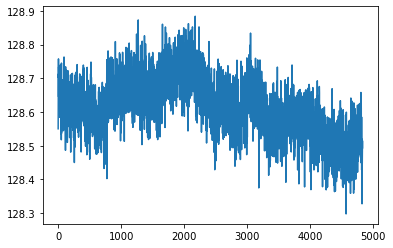

In [83]:
plt.plot(light_curve['frame'],light_curve['illuminance'])

In [84]:
light_curve

frame  illuminance
0         0   128.550090
1         1   128.662144
2         2   128.653799
3         3   128.712568
4         4   128.702863
...     ...          ...
4828   4828   128.450104
4829   4829   128.477717
4830   4830   128.483539
4831   4831   128.514541
4832   4832   128.493422

[4833 rows x 2 columns]

In [85]:
files

name width height frames  \
0    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14550   
1    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14550   
2    /storage/experiments/2021/0605_bourka_radosovi...  1024    768  14549   
3    /storage/experiments/2021/0609_bourka_sobeslav...   800    600   8612   
4    /storage/experiments/2021/0609_bourka_sobeslav...   800    600   8611   
..                                                 ...   ...    ...    ...   
201  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4832   
202  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4833   
203  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4832   
204  /storage/experiments/2021/0822_bourka_sobeslav...     0      0      0   
205  /storage/experiments/2021/0822_bourka_sobeslav...   928    928   4833   

     event_end  event_start  
0       9732.0       9495.0  
1       9918.0       8930.0  
2      11421.0      10061.0  
3       7371.0       3898.0  
4       4125.0       3076.0  
..         ...          ...  
201     2366.0        485.0  
202     4277.0       1115.0  
203     4277.0       1457.0  
204        NaN          NaN  
205     3054.0       3185.0  

[206 rows x 6 columns]